In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import f_class
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
objective = f_class.sin(Noise, Noise_level)
objective = f_class.Ackley_1(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, 1)

clean_f = lambda x: f_class.sin().func(x)
clean_f = lambda x: f_class.Schwefel(dim=1).func(x)
clean_f = lambda x: f_class.Ackley_1().func(x)


B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
lb = B[:, 0]; ub = B[:, 1]

f = objective.func
print(f( np.array([2]) ))

dim = objective.input_dim
print('dim: ', dim)

[[0.65935991]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100

In [5]:
# set seed
seed = 1
def draw(n_random_draws=3):
    X = np.random.uniform(lb, ub, size=(n_random_draws, dim))
    return X, f(X)

def optimize_hyper(lb, ub, sample_size=200):
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper
# gp = GP_grad(B, Noise, Noise_level, compress=False)
# (ls, var) = optimize_hyper(lb, ub, sample_size=1000)
# del gp
# (ls, var)

In [7]:
gp = GP_grad(B, Noise, Noise_level, compress=False)

# set optimized hyper
# gp.set_hyper(ls, var)

# put in some random data (let them to be close)
init_size = 4
X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))

# X = np.zeros((init_size, dim))

# sample from a small 2d box
# Xc = np.random.uniform(lb, ub, size=(1, dim))

# X[0] = Xc
# for i in range(1, init_size):
#     X[i] = Xc + 0.5*np.random.uniform(-1, 1, Xc.shape)

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

array([[ 74.6913998 ],
       [  3.92473107],
       [ -5.50869169],
       [-69.36965621]])

In [8]:
f(X), gp.posterior(X)

(array([[0.37590362],
        [0.77070753],
        [0.42014214],
        [0.35731296]]),
 (array([[0.37582818],
         [0.77070357],
         [0.42014771],
         [0.35738302]]),
  array([[ 1.00467156e-06, -5.17540143e-11,  3.86793292e-10,
           5.04926437e-09],
         [-5.17540143e-11,  1.00999466e-06,  6.01955985e-12,
           4.76825714e-11],
         [ 3.86793292e-10,  6.01955985e-12,  1.00996229e-06,
          -3.59839436e-10],
         [ 5.04926437e-09,  4.76825714e-11, -3.59839436e-10,
           1.00520634e-06]])))

In [9]:
gp.get_hyper()

{'var': 0.23748810936125156, 'lengthscale': 0.5551830650069545}

In [10]:
# Grid -> test points for plotting
n_Grid = 500
Grid = np.linspace(lb, ub, n_Grid).reshape(-1, dim)

mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

Kt = gp.cov_RBF(Grid, Grid, gp.get_hyper())
K_11 = gp.K11(Grid)
K_01 = gp.K01(Grid)

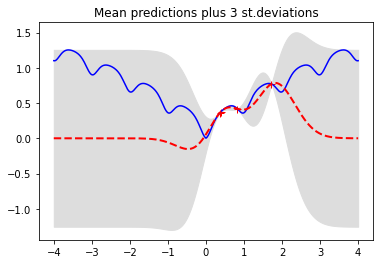

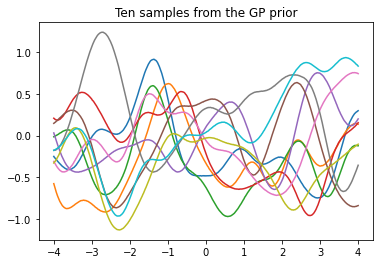

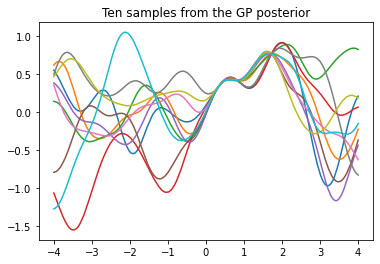

In [11]:
# plot
pl.figure(1)
pl.clf()
pl.plot(gp.X, gp.y, 'r+', ms=7)
pl.plot(Grid, clean_f(Grid), 'b-')
pl.gca().fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

pl.plot(Grid, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP prior')
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP posterior')
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [12]:
mu_grad, covar_grad = gp.posterior_grad(Grid)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [13]:
from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

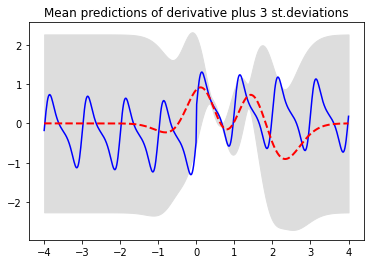

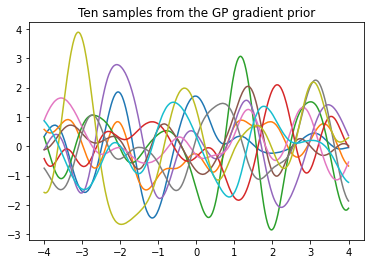

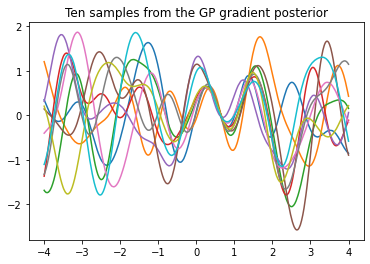

In [14]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(Grid, approx_grad, 'b-')
pl.gca().fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

pl.plot(Grid, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient Descent 

In [15]:
n_iter = 40
lr = 0.1
lr_init = 15
alpha = 0.5

history = []
history_lr = []


w = X[0]
# arg_min = np.argmin(f(X))
# w = X[arg_min] # min value to start
w

array([0.39050803])

In [16]:
def grad(gp, x): # input a fit gp, find the gradient at x
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return m1.reshape(-1, 1)

def grad_sample(gp, x):
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return np.random.normal(m1.item(), s1.item(), 1).reshape((-1, 1))


grad(gp, w), grad_sample(gp, w), optimize.approx_fprime(w, lambda x: clean_f(x).item(), eps)

(array([[0.55107452]]), array([[0.54976425]]), array([0.55420156]))

In [17]:
gp.posterior(w), clean_f(w)
gp.posterior_grad(w), optimize.approx_fprime(w, lambda x: clean_f(x).item(), eps)

((array([[0.55107452]]), array([[0.00198345]])), array([0.55420156]))

In [18]:
# approximated grad on mesh points
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

In [19]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
lr = 0.01
mt = np.array([0])
vt = np.array([0])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

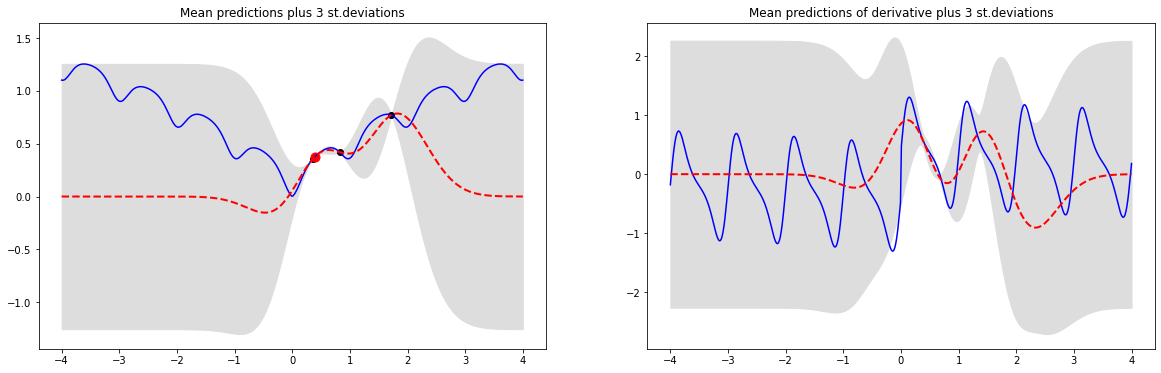

w:  [[0.33149998]]
lr:  0.1
df: [[0.67896514]], s.d. [[0.00473434]]
actual df [0.7098923]


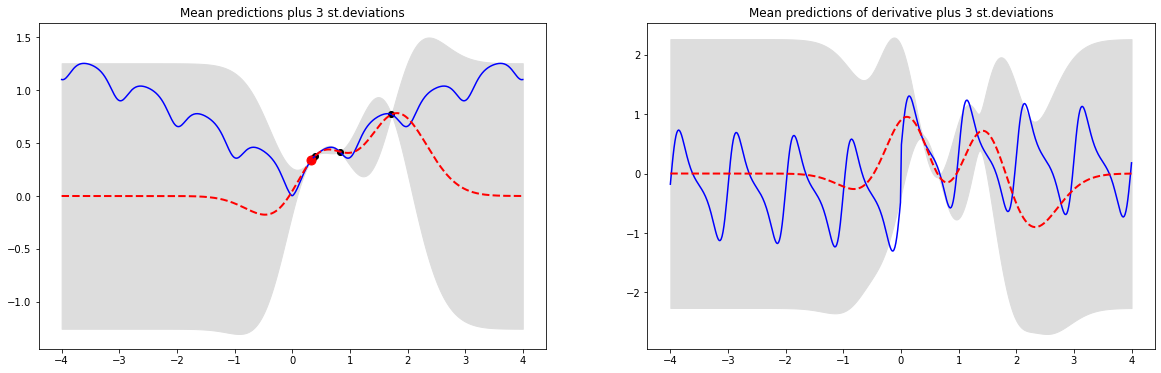

w:  [[0.26177776]]
lr:  0.1
df: [[0.82239054]], s.d. [[0.01372009]]
actual df [0.96153941]


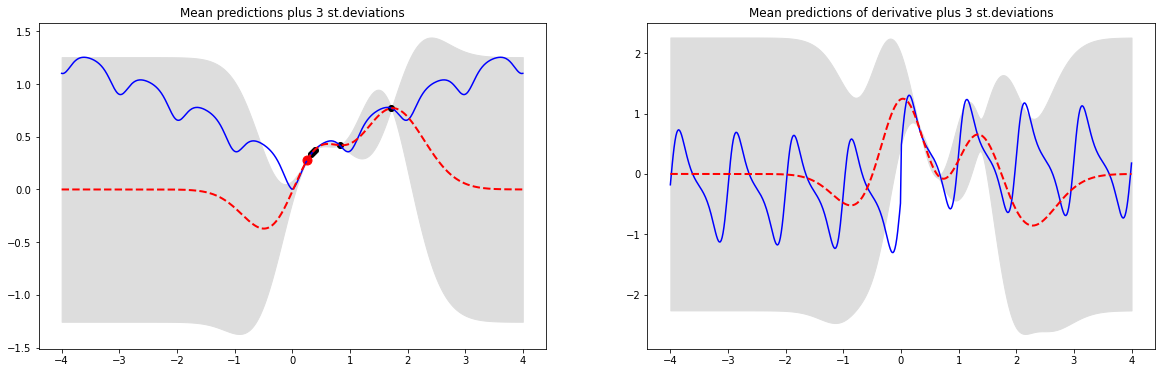

w:  [[0.16960483]]
lr:  0.1
df: [[1.12296086]], s.d. [[0.0116778]]
actual df [1.27874918]


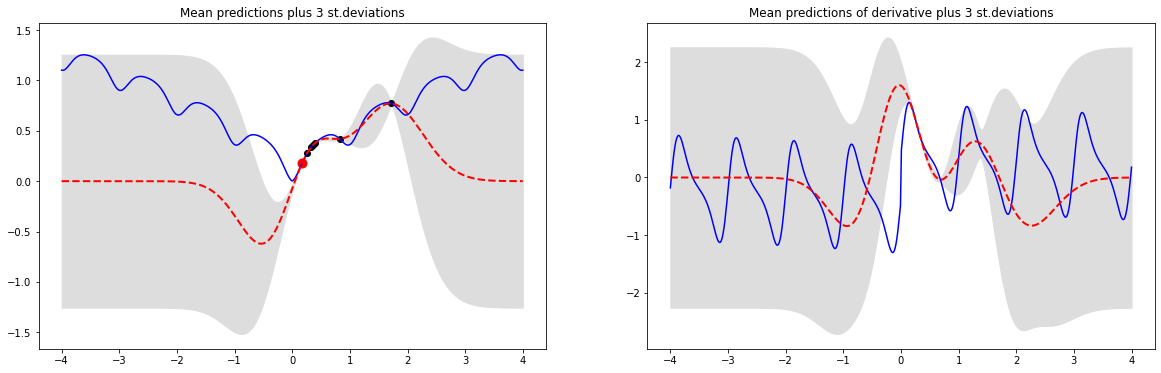

w:  [[0.03963995]]
lr:  0.1
df: [[1.55780238]], s.d. [[0.01404567]]
actual df [0.80505455]


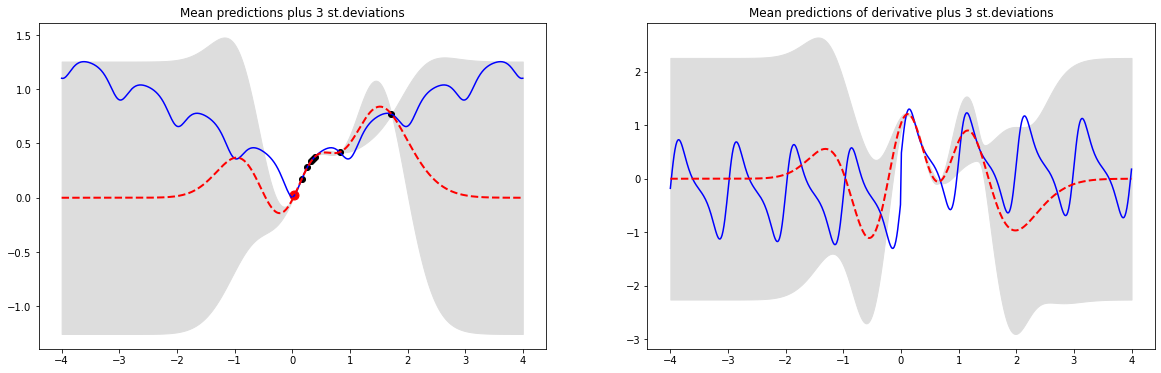

w:  [[-0.07285914]]
lr:  0.1
df: [[0.75727612]], s.d. [[0.01134442]]
actual df [-1.07520785]


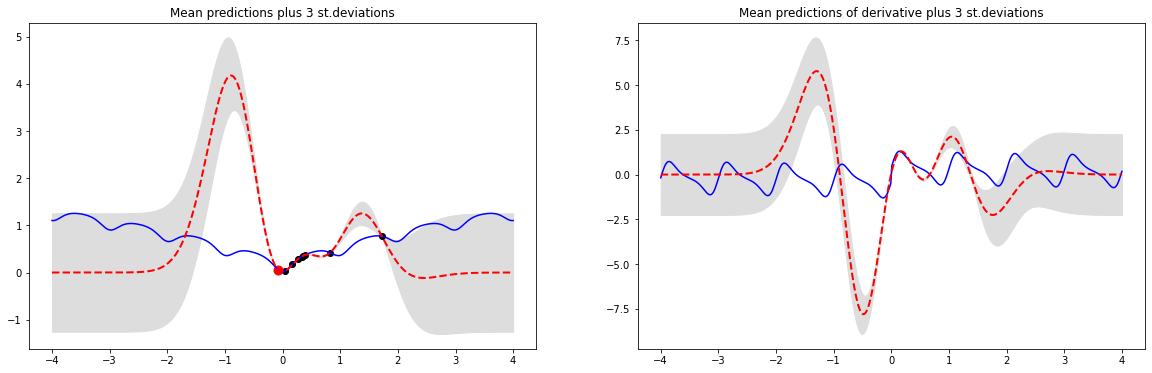

w:  [[0.04129425]]
lr:  0.1
df: [[0.60398438]], s.d. [[5.00566537e-05]]
actual df [0.82047386]


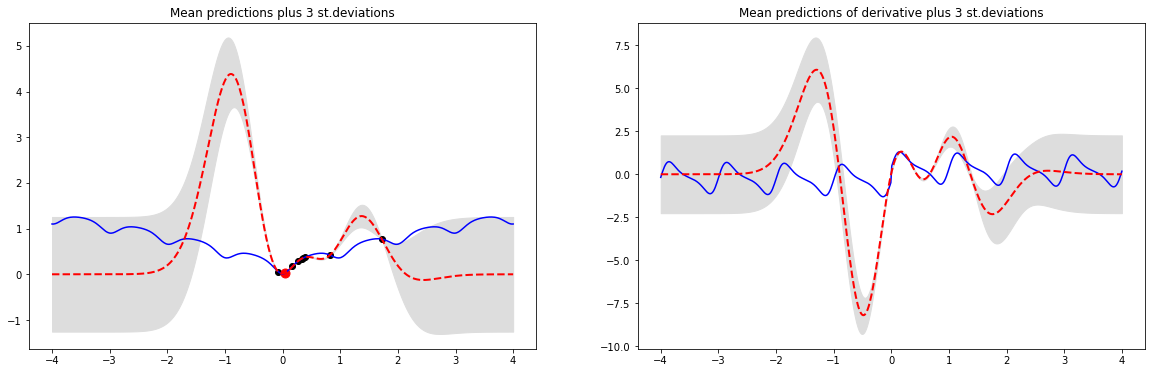

w:  [[-0.01980003]]
lr:  0.1
df: [[-0.2319316]], s.d. [[0.00011135]]
actual df [-0.60872068]


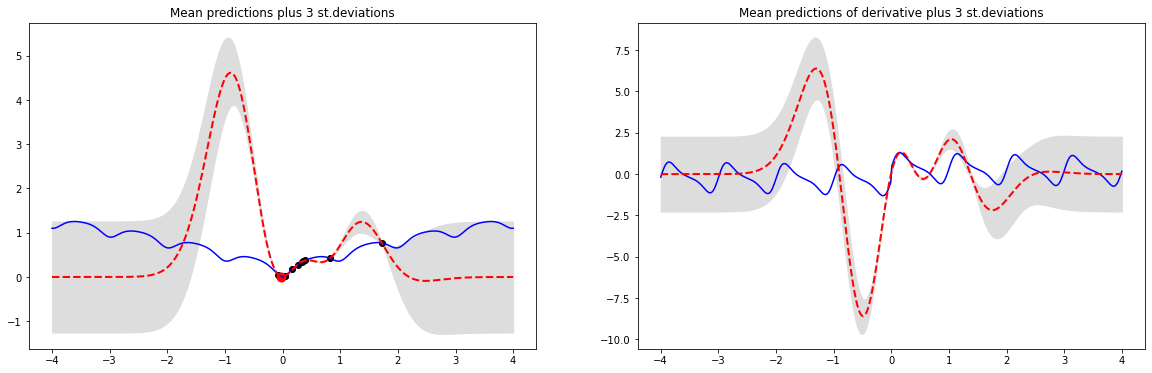

w:  [[0.00146761]]
lr:  0.1
df: [[0.1023955]], s.d. [[6.65328719e-05]]
actual df [0.41563118]


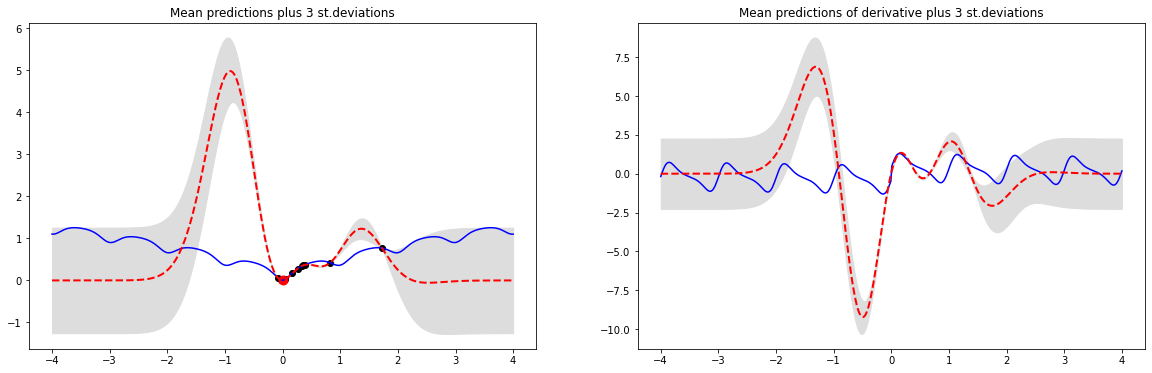

w:  [[-0.00733342]]
lr:  0.1
df: [[-0.03885369]], s.d. [[8.01572366e-05]]
actual df [-0.47799988]


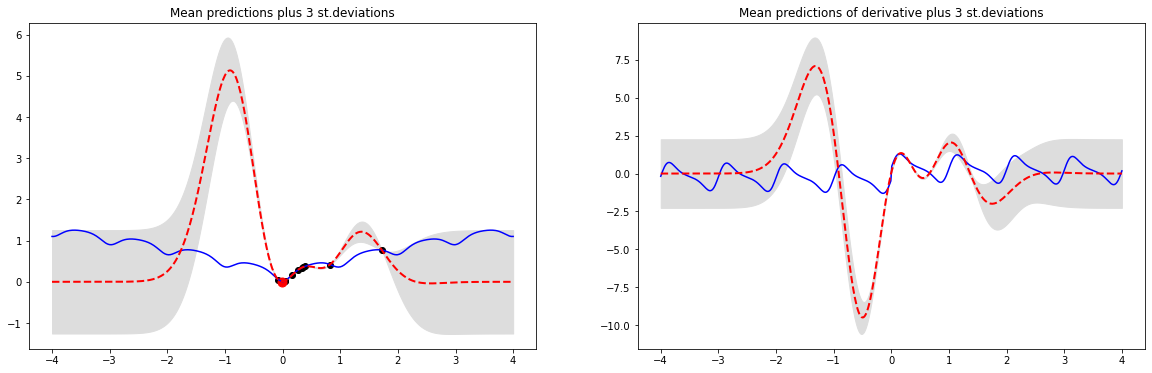

w:  [[-0.00332155]]
lr:  0.1
df: [[0.02545333]], s.d. [[7.33048102e-05]]
actual df [-0.43536868]


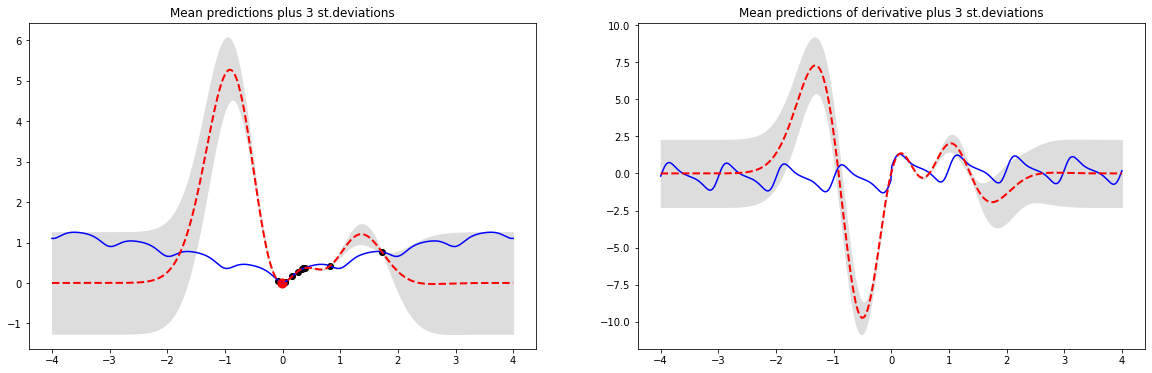

w:  [[-0.00398405]]
lr:  0.1
df: [[0.01373679]], s.d. [[7.43317853e-05]]
actual df [-0.44241767]


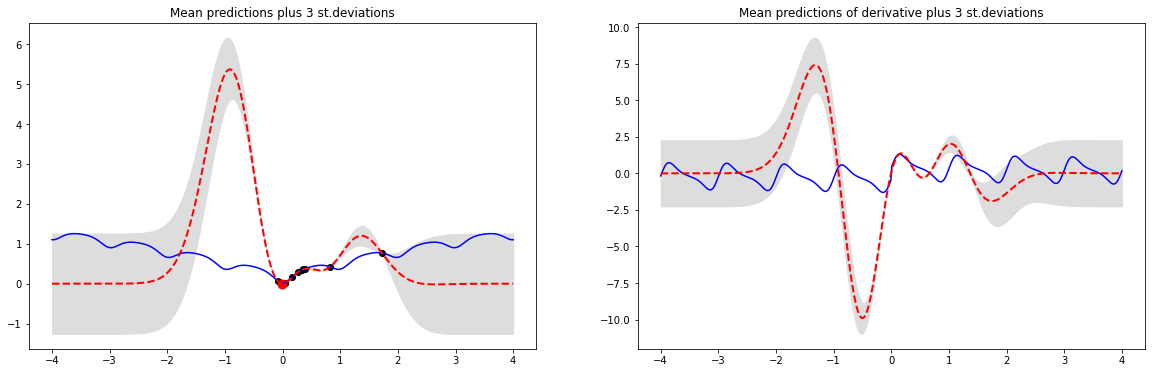

w:  [[-0.00581932]]
lr:  0.1
df: [[-0.01680782]], s.d. [[7.7364493e-05]]
actual df [-0.46192815]


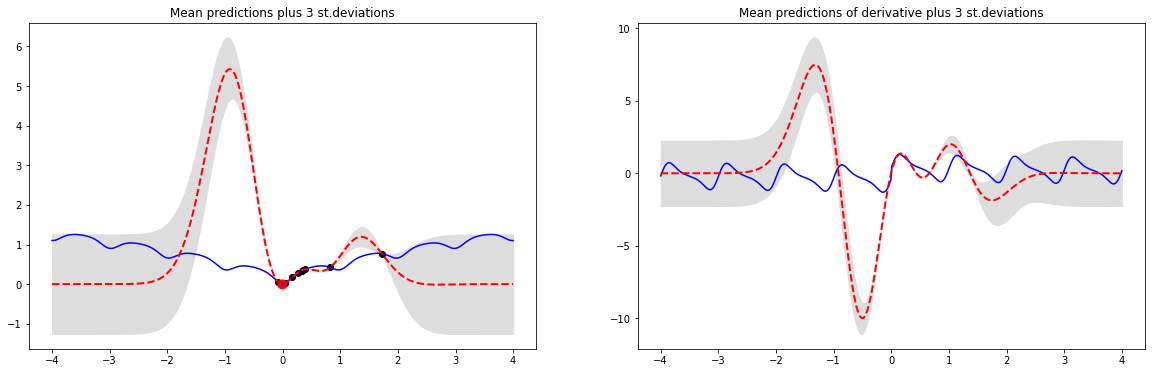

w:  [[-0.00456189]]
lr:  0.1
df: [[0.00380649]], s.d. [[7.52561754e-05]]
actual df [-0.44856353]


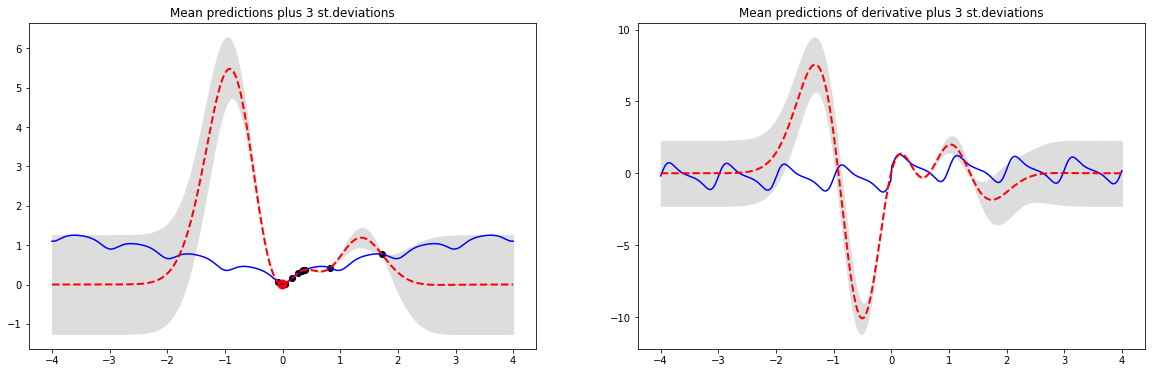

w:  [[-0.00668866]]
lr:  0.1
df: [[-0.03164912]], s.d. [[7.88612799e-05]]
actual df [-0.47115908]


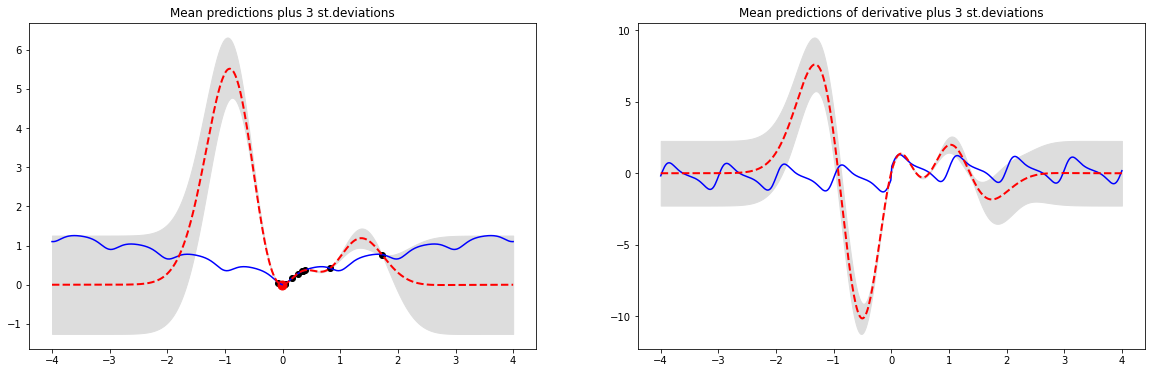

w:  [[-0.00292332]]
lr:  0.1
df: [[0.03058687]], s.d. [[7.26271222e-05]]
actual df [-0.43113024]


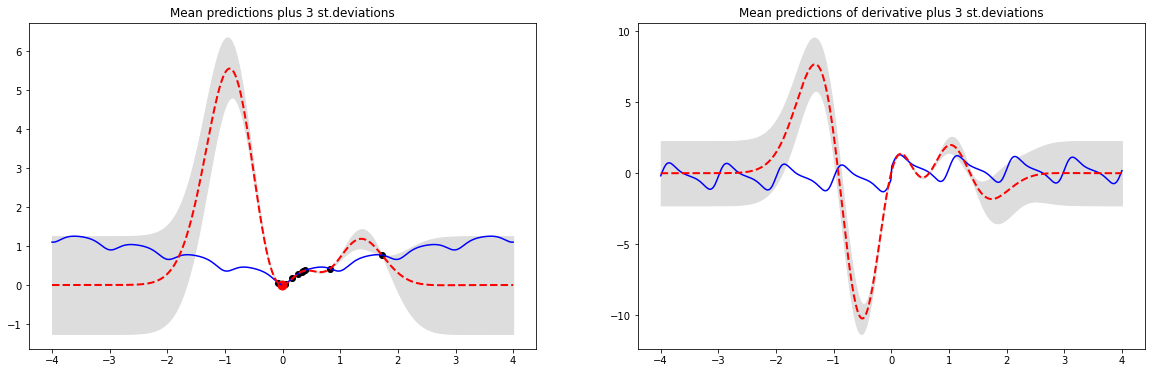

w:  [[-0.00624308]]
lr:  0.1
df: [[-0.02493742]], s.d. [[7.80305461e-05]]
actual df [-0.4664288]


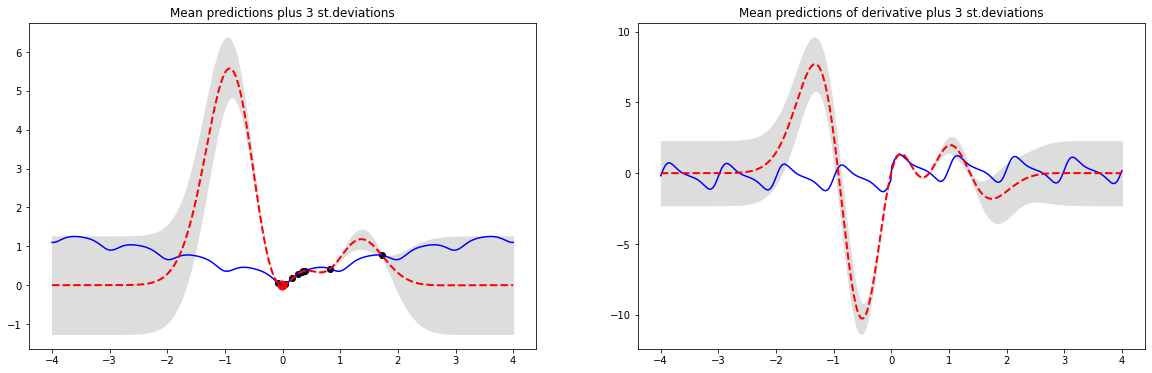

w:  [[-0.00410117]]
lr:  0.1
df: [[0.01074533]], s.d. [[7.44541201e-05]]
actual df [-0.44366353]


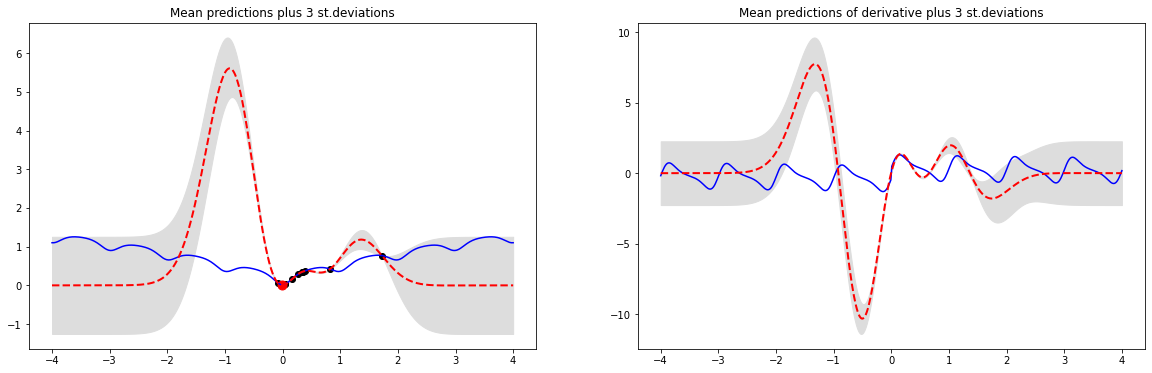

w:  [[-0.00619631]]
lr:  0.1
df: [[-0.02440893]], s.d. [[7.79335722e-05]]
actual df [-0.46593213]


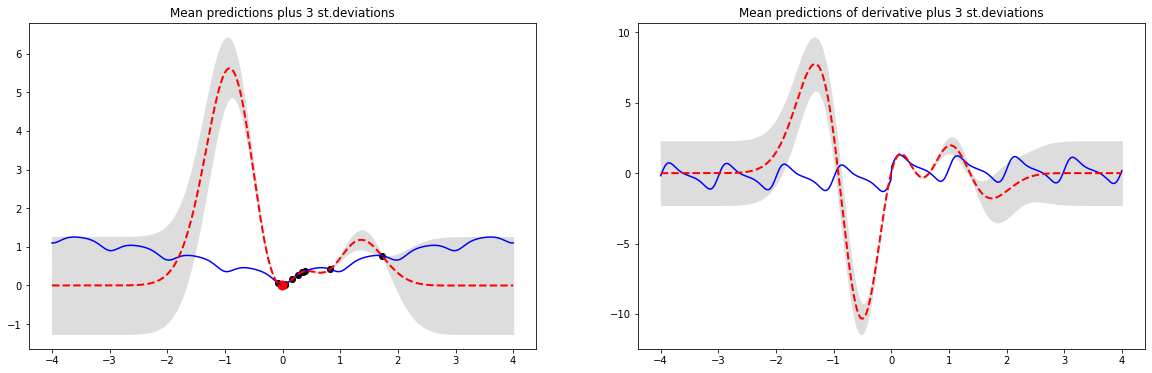

w:  [[-0.00386273]]
lr:  0.1
df: [[0.01454877]], s.d. [[7.40588778e-05]]
actual df [-0.44112704]


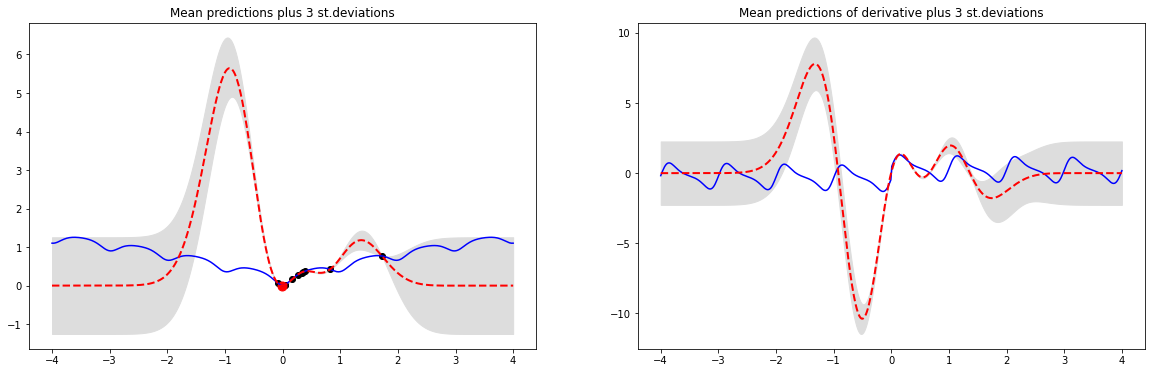

w:  [[-0.00439805]]
lr:  0.1
df: [[0.00539498]], s.d. [[7.49092427e-05]]
actual df [-0.44682119]


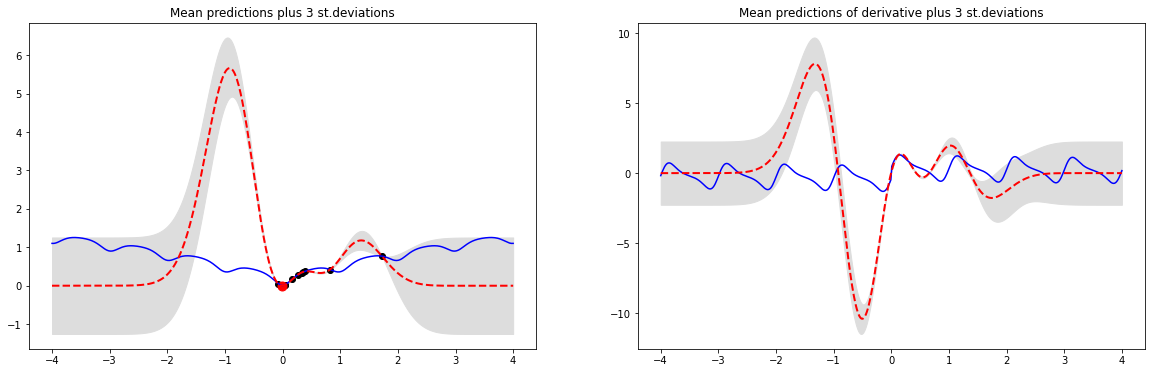

w:  [[-0.00622769]]
lr:  0.1
df: [[-0.02538495]], s.d. [[7.79608097e-05]]
actual df [-0.46626537]


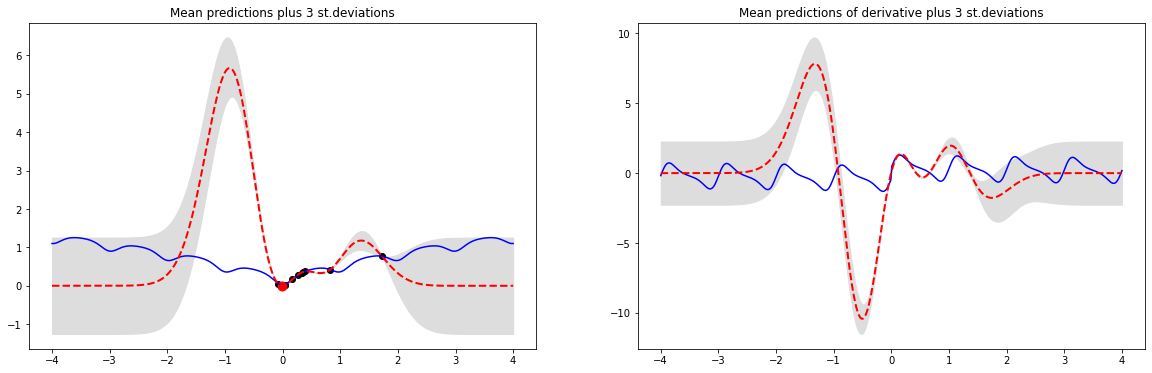

w:  [[-0.00327505]]
lr:  0.1
df: [[0.02399625]], s.d. [[7.31098961e-05]]
actual df [-0.4348738]


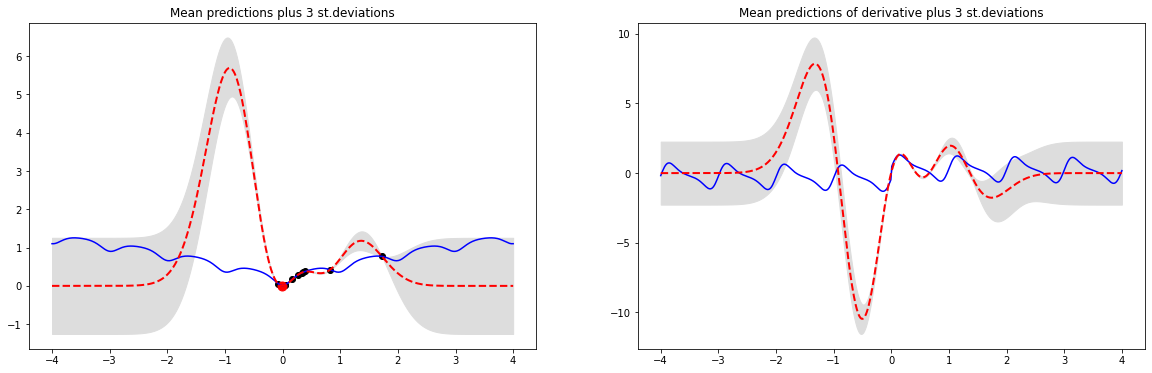

w:  [[-0.00674621]]
lr:  0.1
df: [[-0.03448365]], s.d. [[7.8827859e-05]]
actual df [-0.47176981]


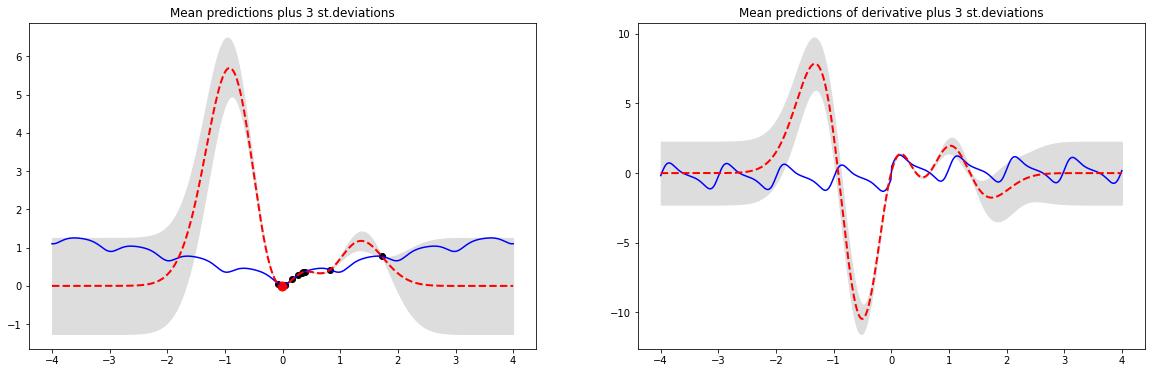

w:  [[-0.00445631]]
lr:  0.1
df: [[0.00410541]], s.d. [[7.49596517e-05]]
actual df [-0.44744077]


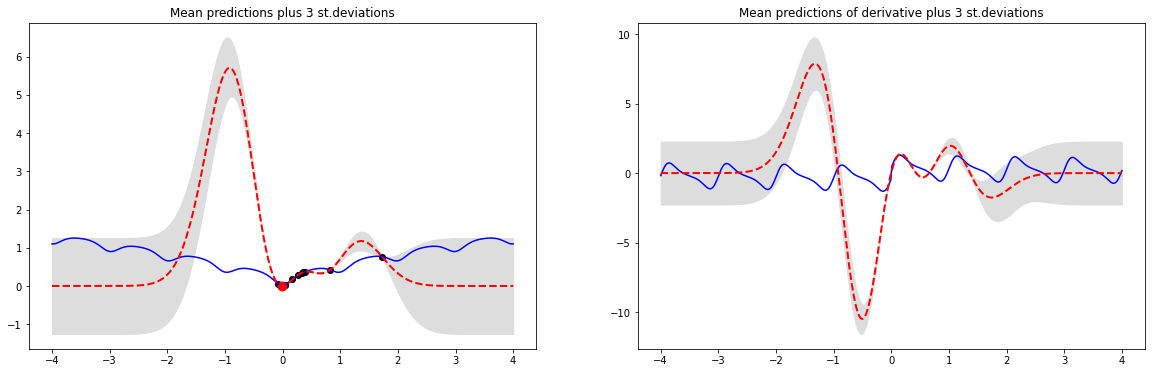

w:  [[-0.00582126]]
lr:  0.1
df: [[-0.01891243]], s.d. [[7.72205819e-05]]
actual df [-0.46194875]


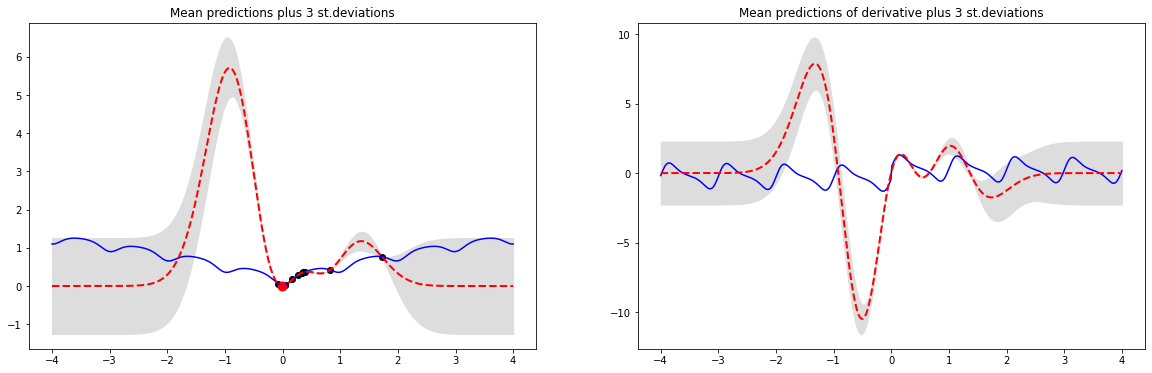

w:  [[-0.00408938]]
lr:  0.1
df: [[0.01017718]], s.d. [[7.43617994e-05]]
actual df [-0.44353814]


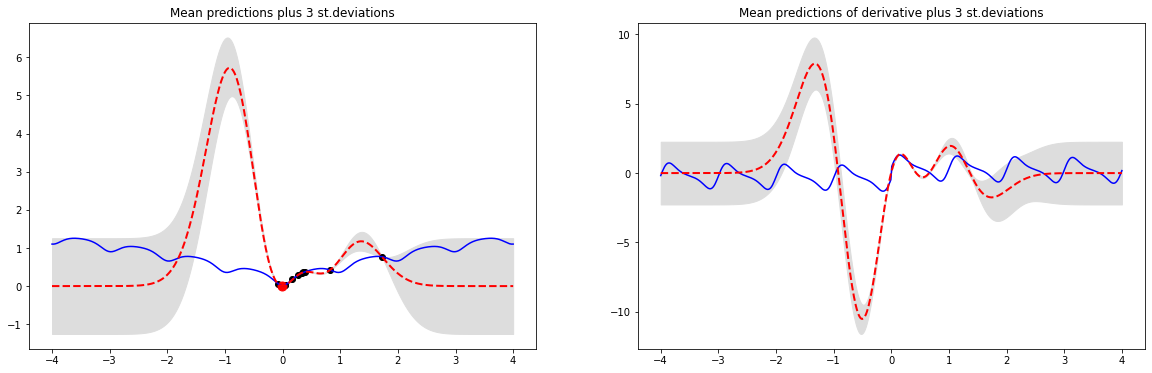

w:  [[-0.00484451]]
lr:  0.1
df: [[-0.00261147]], s.d. [[7.55805705e-05]]
actual df [-0.4515686]


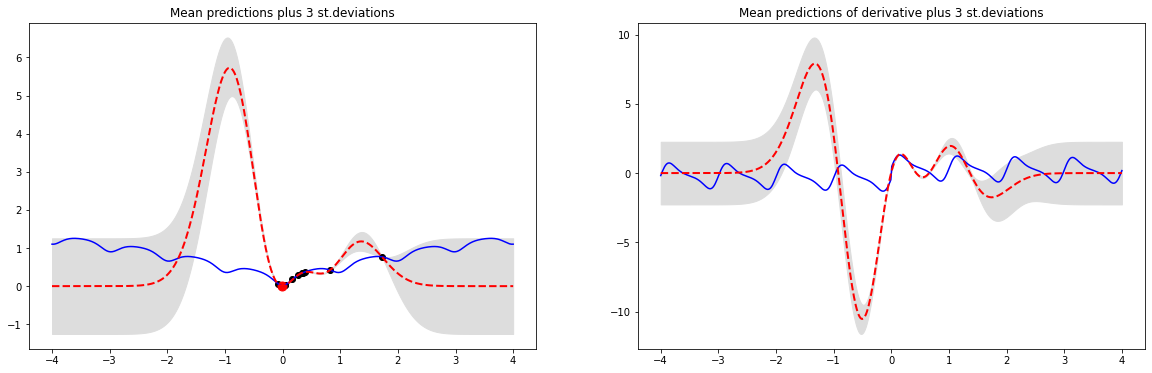

w:  [[-0.00584585]]
lr:  0.1
df: [[-0.01951481]], s.d. [[7.72503368e-05]]
actual df [-0.46221004]


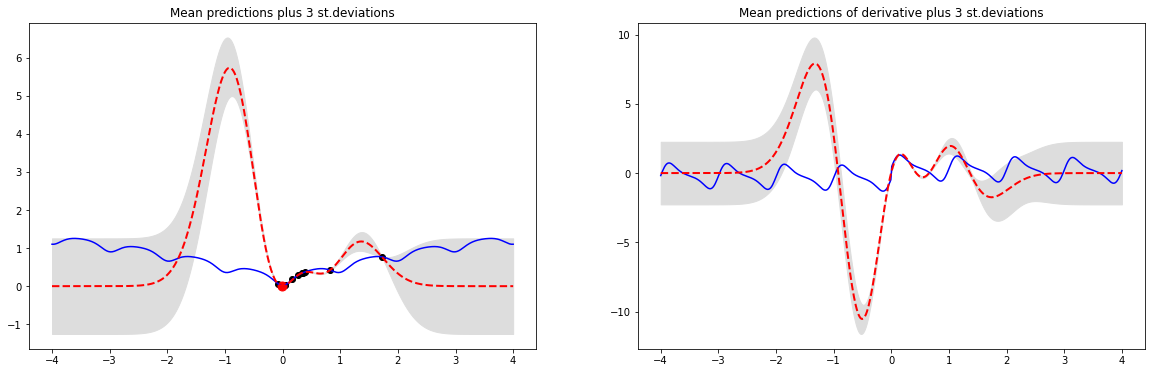

w:  [[-0.00464501]]
lr:  0.1
df: [[0.00073599]], s.d. [[7.52509198e-05]]
actual df [-0.44944746]


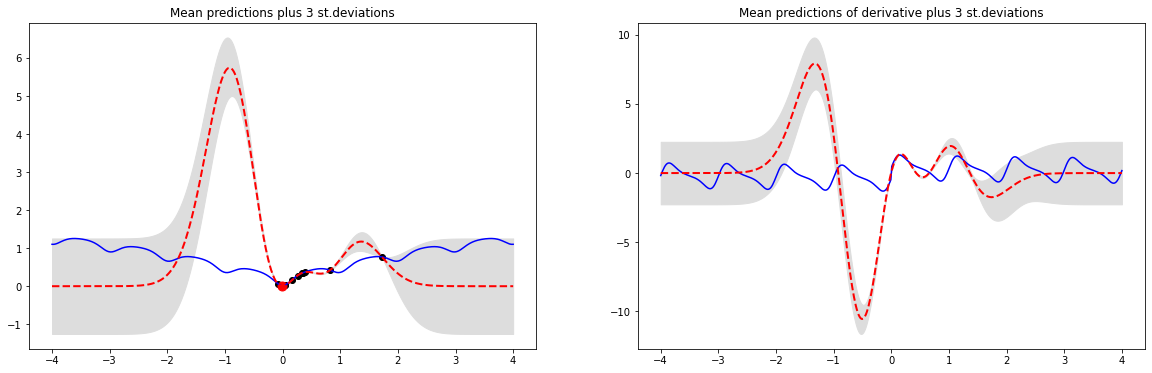

w:  [[-0.00438039]]
lr:  0.1
df: [[0.00511489]], s.d. [[7.48189798e-05]]
actual df [-0.44663336]


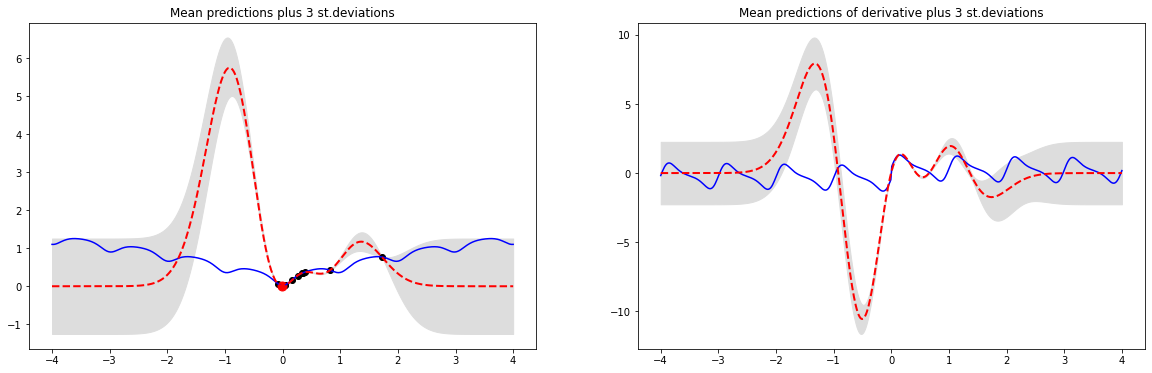

w:  [[-0.00434603]]
lr:  0.1
df: [[0.00560646]], s.d. [[7.47598818e-05]]
actual df [-0.44626794]


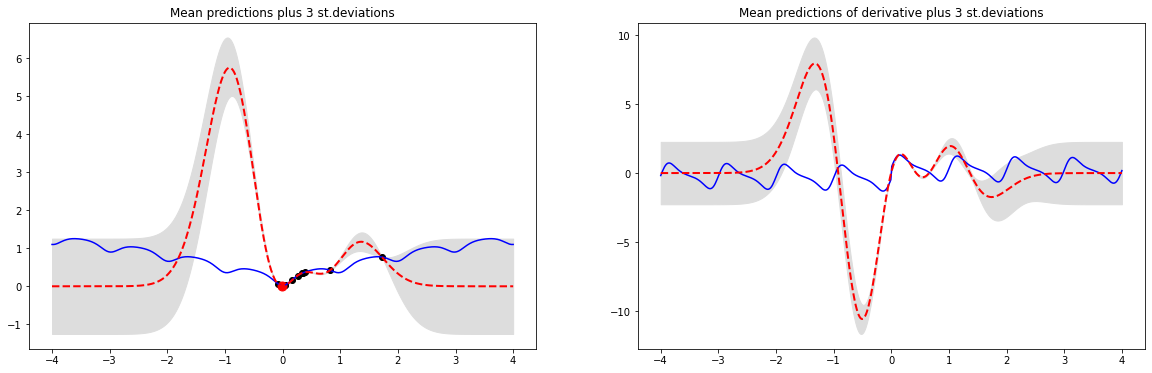

w:  [[-0.00680842]]
lr:  0.1
df: [[-0.03608376]], s.d. [[7.88906277e-05]]
actual df [-0.47243009]


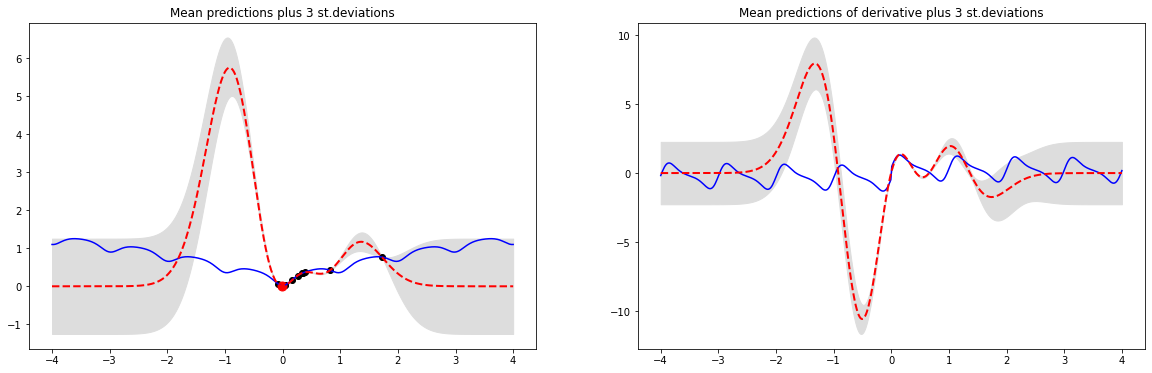

w:  [[-0.00416146]]
lr:  0.1
df: [[0.00865072]], s.d. [[7.44433668e-05]]
actual df [-0.44430485]


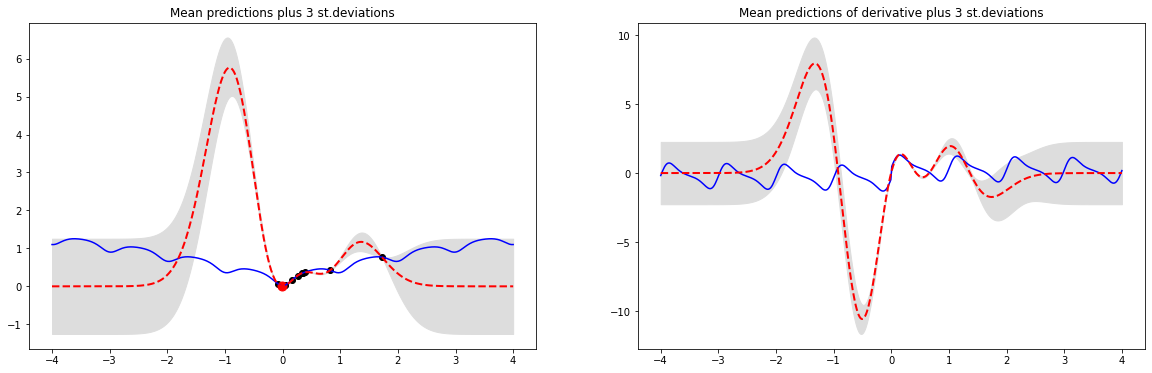

w:  [[-0.00598833]]
lr:  0.1
df: [[-0.02224824]], s.d. [[7.74568685e-05]]
actual df [-0.46372335]


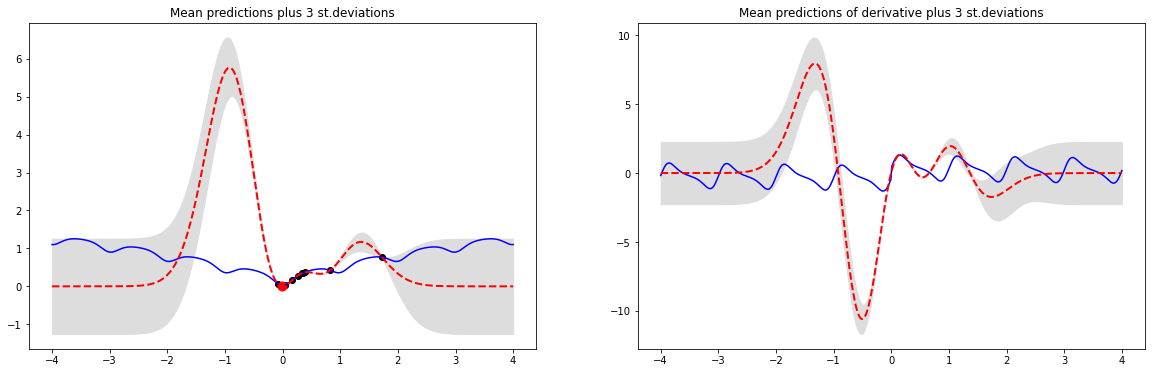

w:  [[-0.00389537]]
lr:  0.1
df: [[0.01303908]], s.d. [[7.40083117e-05]]
actual df [-0.44147434]


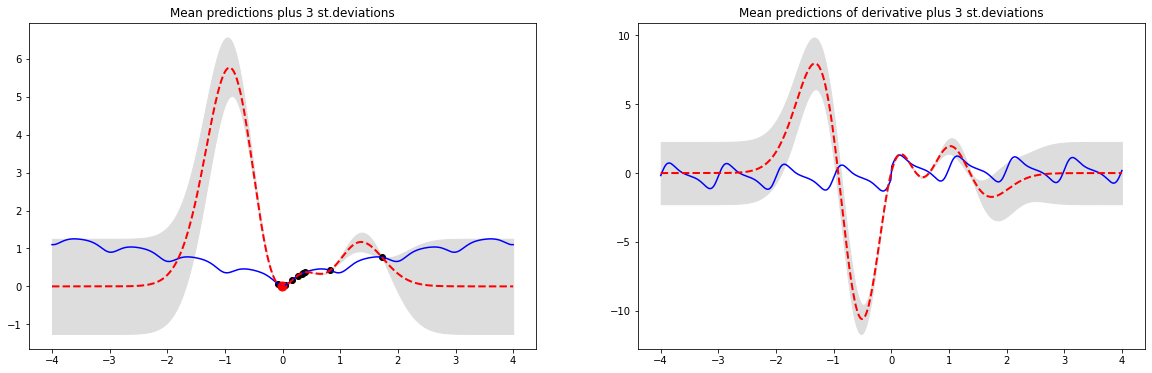

w:  [[-0.00428768]]
lr:  0.1
df: [[0.00632751]], s.d. [[7.46282394e-05]]
actual df [-0.44564745]


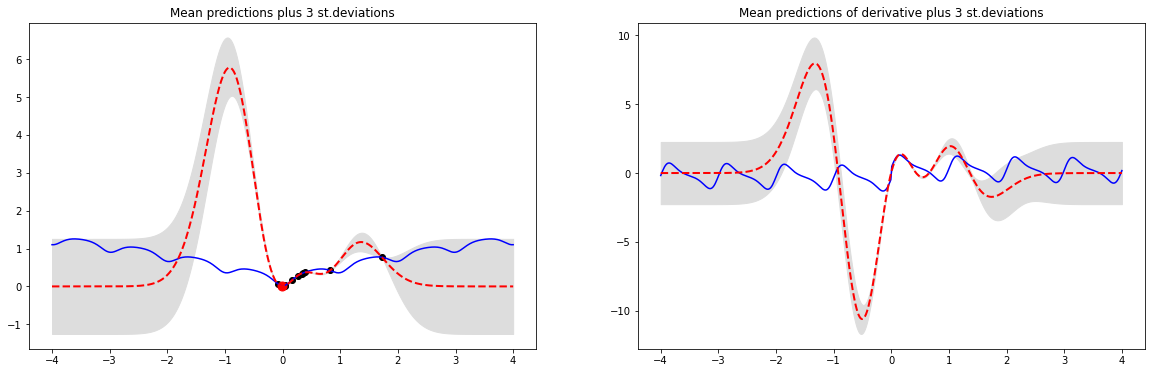

w:  [[-0.00518165]]
lr:  0.1
df: [[-0.00880456]], s.d. [[7.60846151e-05]]
actual df [-0.45515234]


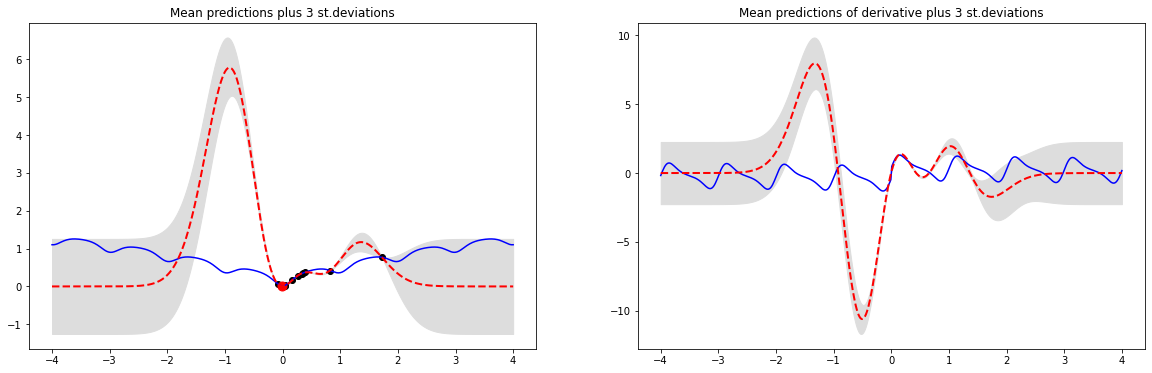

w:  [[-0.00513229]]
lr:  0.1
df: [[-0.00797039]], s.d. [[7.60029256e-05]]
actual df [-0.45462778]


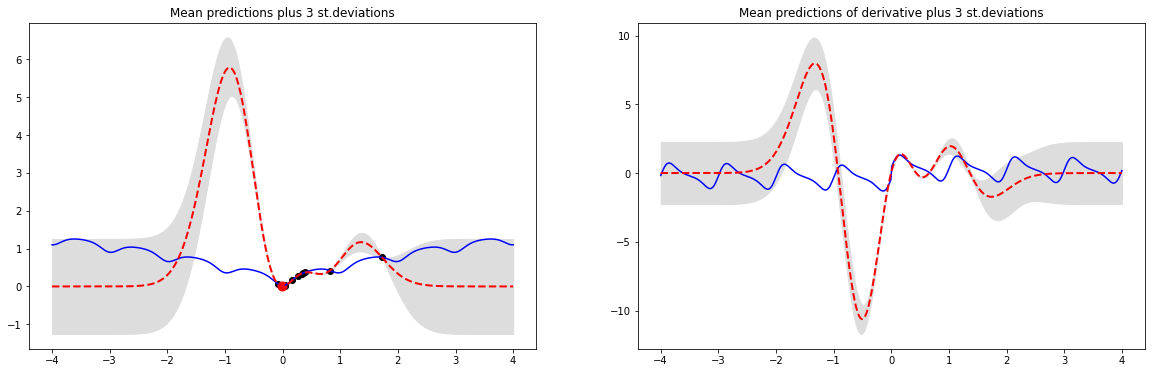

w:  [[-0.0042157]]
lr:  0.1
df: [[0.00746516]], s.d. [[7.45084837e-05]]
actual df [-0.44488175]


In [20]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(gp.X, gp.y, 'ko', markersize=6)
    ax1.plot(w, f(w), 'ro', markersize=9)
    
    ax1.plot(Grid.flat, clean_f(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

    ax1.plot(Grid, mu, 'r--', lw=2)
    fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')

    filename = 'Ackley_' + str(i) + '_demo' +'.png' # name for different 
    pl.savefig('1D_Plots/' + filename)
    pl.show()  

    # 1. gradient descent
    lr = 0.1
    w = np.clip(w - lr * grad_sample(gp, w), lb, ub)

    #     2. nesterov
#     lr = 0.01
#     v = 0.9*v + lr*grad(gp, w-0.9*v)
#     w = np.clip(w - v, lb, ub)
    
    # 3. Adam
    # approximate first and second moment
#     gt = grad(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * lr * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w
    
    print('w: ', w)
    print('lr: ', lr)
    m, v = gp.posterior_grad(w)
    print('df:', m, end=', ')
    print('s.d.', v)
    print('actual df', optimize.approx_fprime(w[0], lambda x: clean_f(x).item(), eps))
#     print('desc:', -gt)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    if i % 5 == 1:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

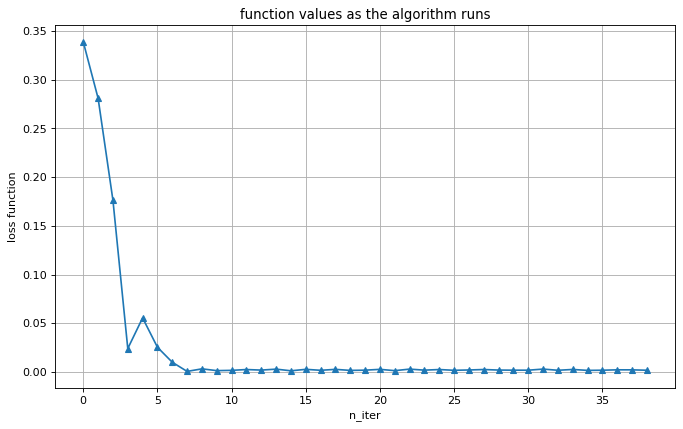

In [21]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [21]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

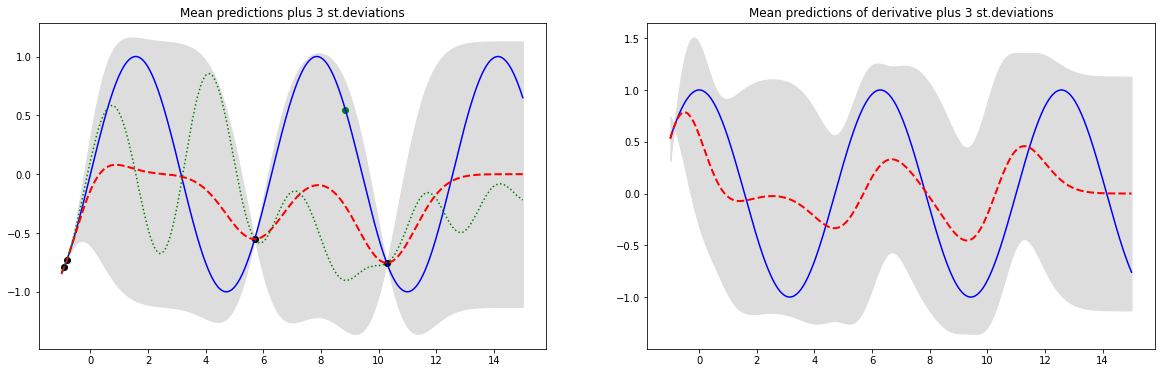

w:  [8.84368737]


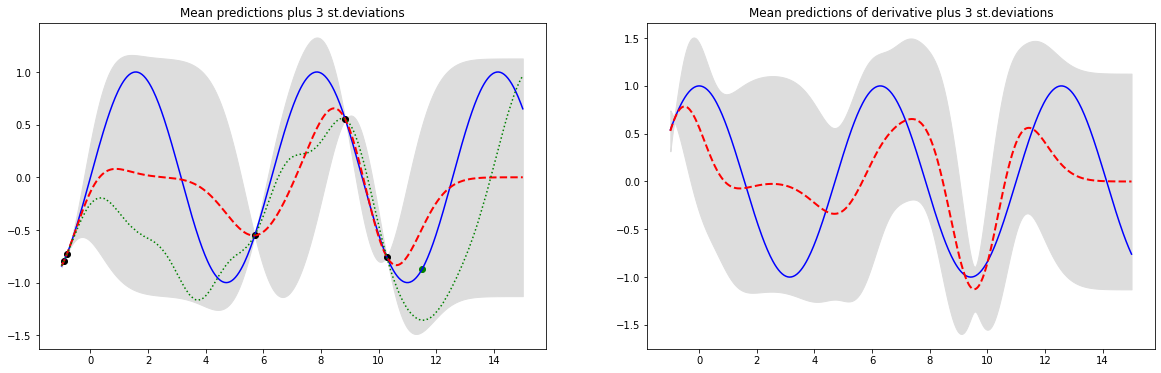

w:  [11.50501002]


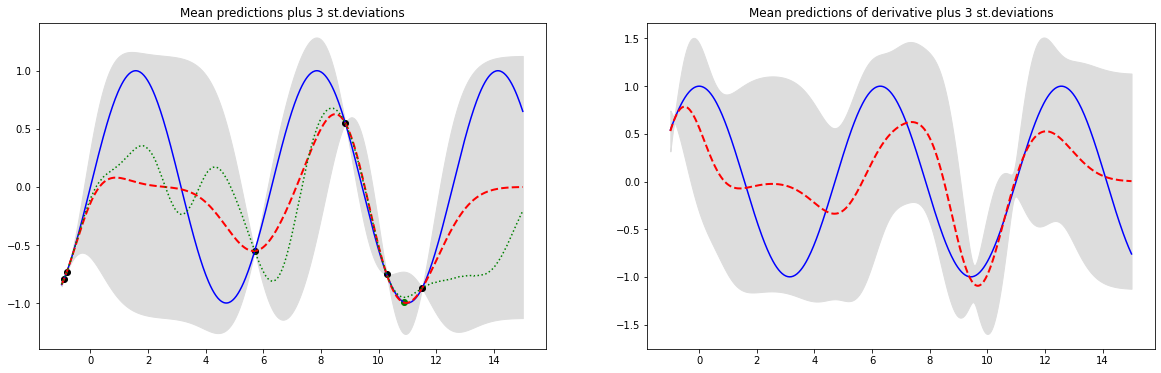

w:  [10.89579158]


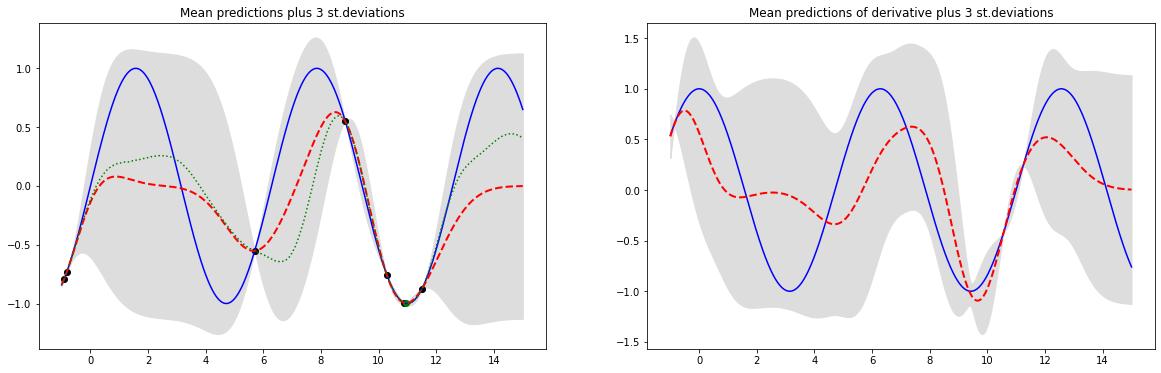

w:  [10.95991984]


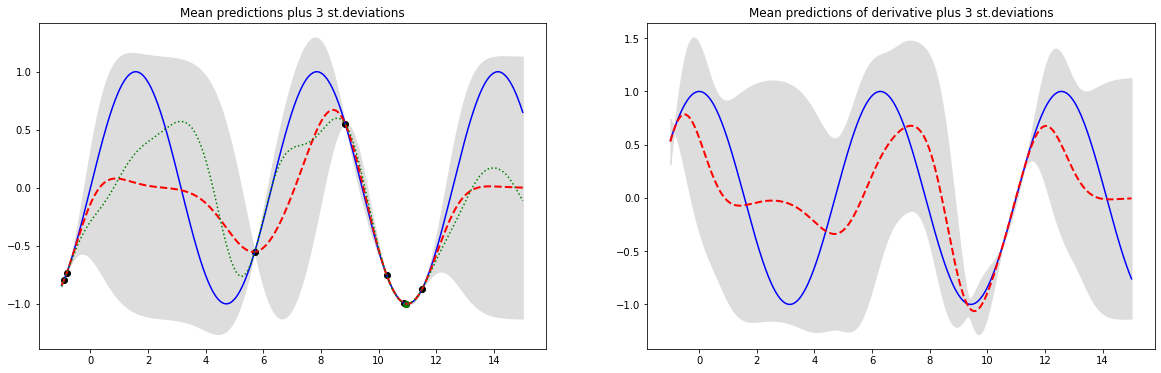

w:  [10.95991984]


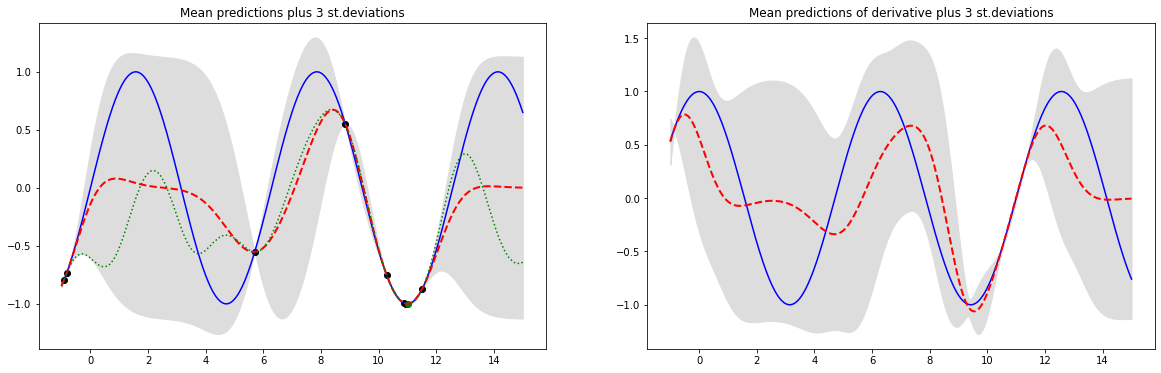

w:  [11.0240481]


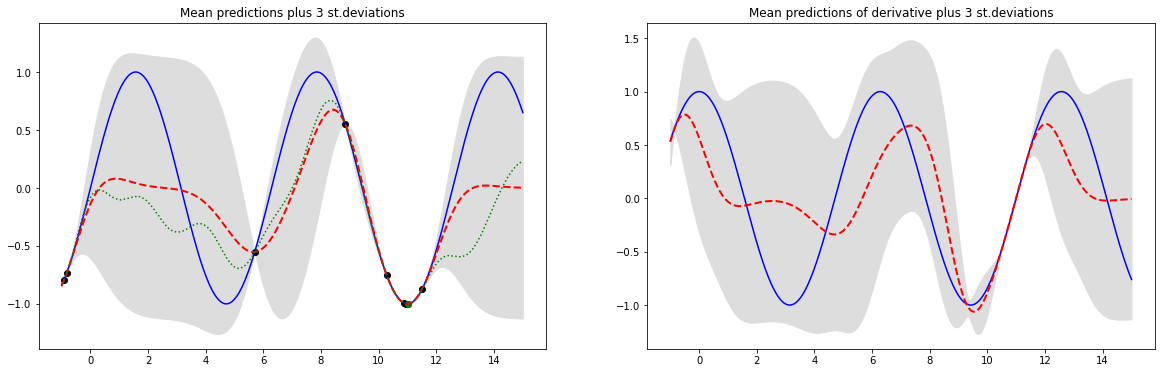

w:  [11.0240481]


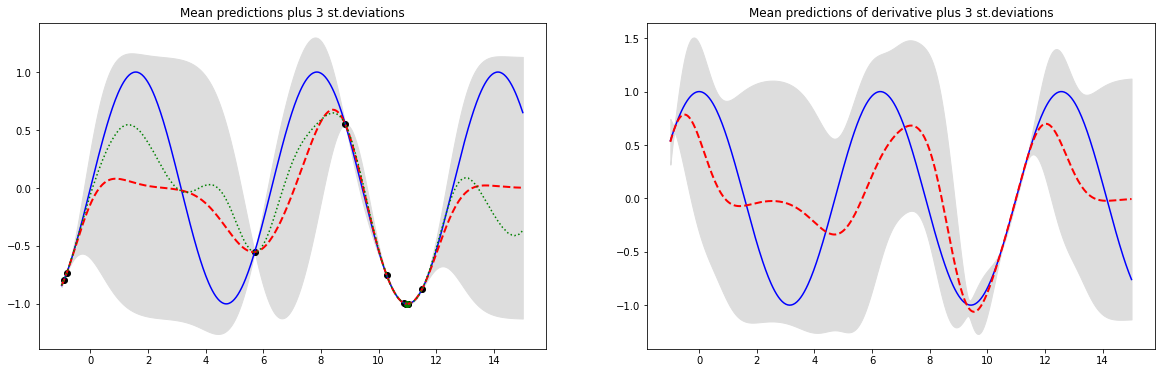

w:  [10.99198397]


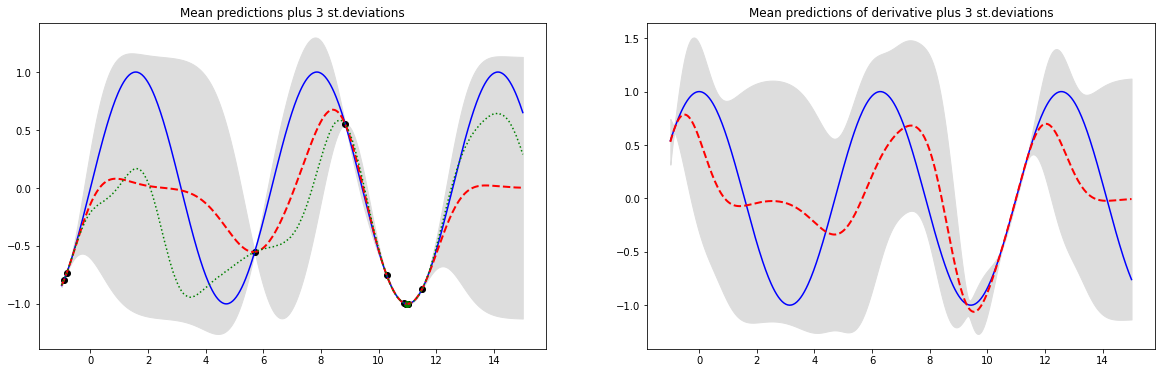

w:  [10.99198397]


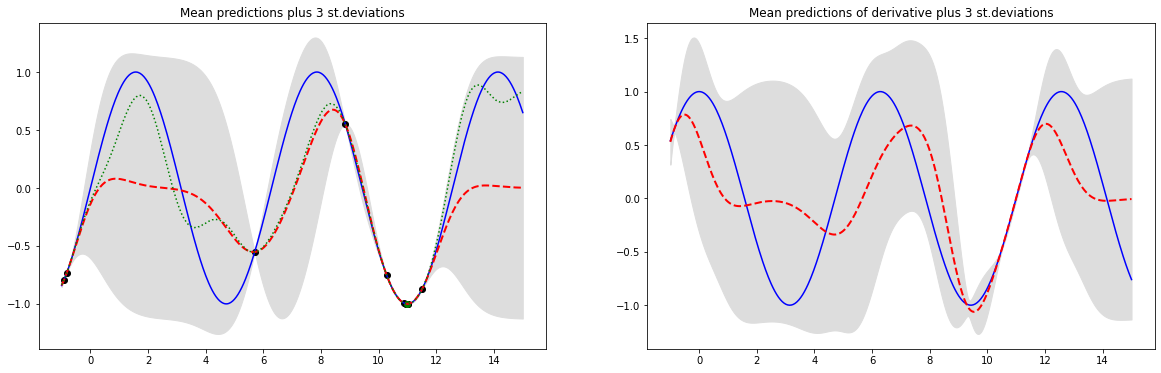

w:  [10.99198397]


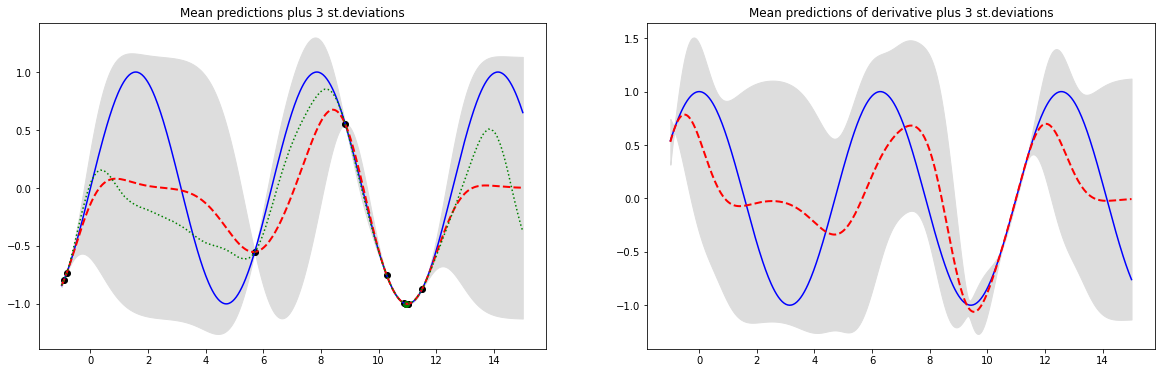

w:  [10.95991984]


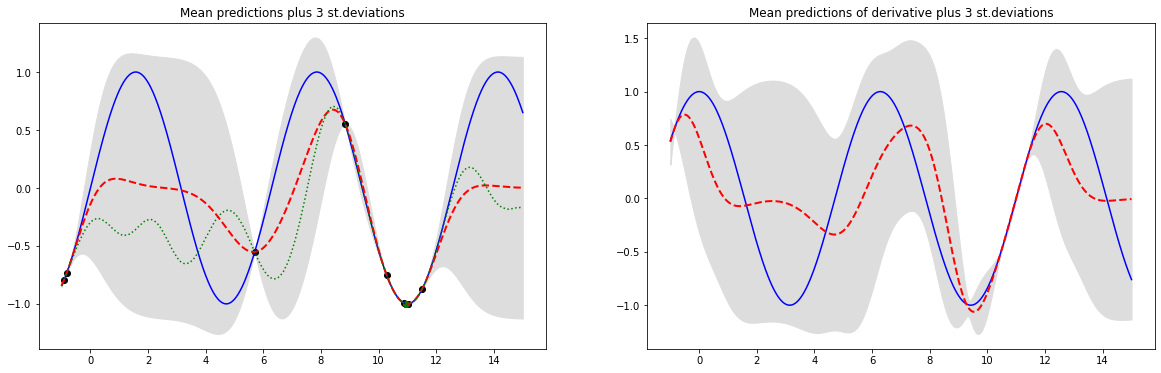

w:  [10.95991984]


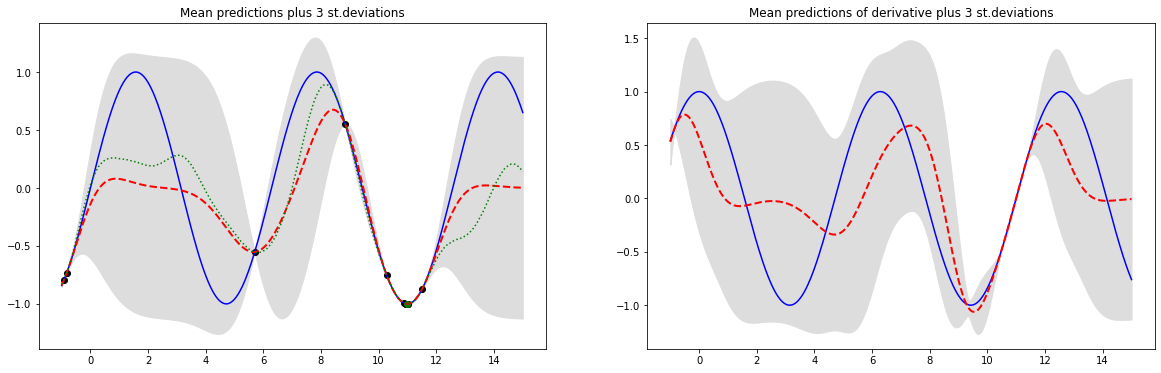

w:  [10.99198397]


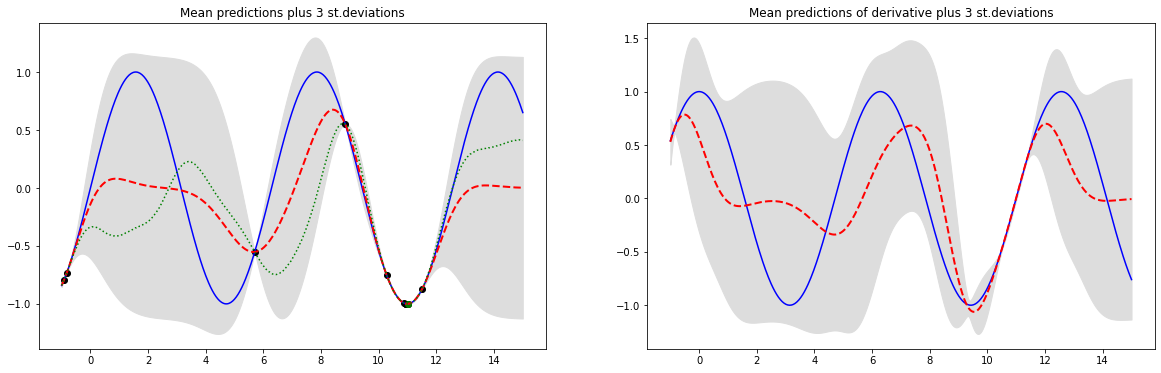

w:  [11.0240481]


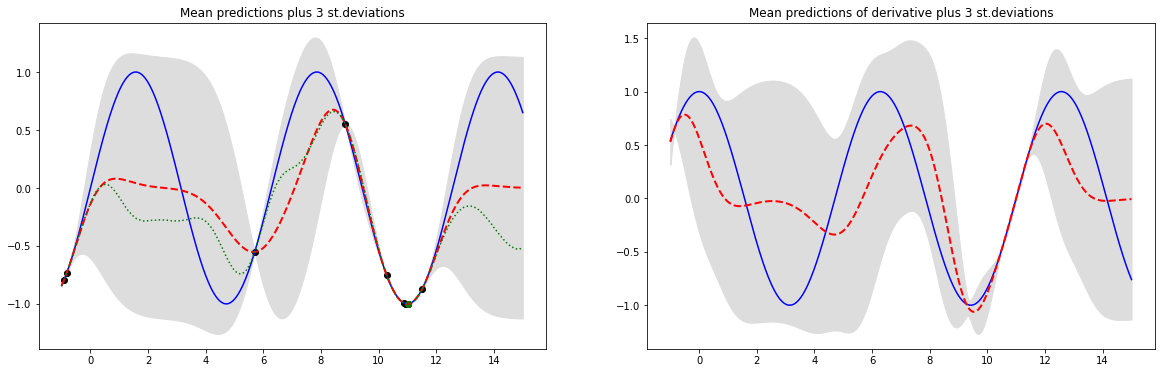

w:  [11.0240481]


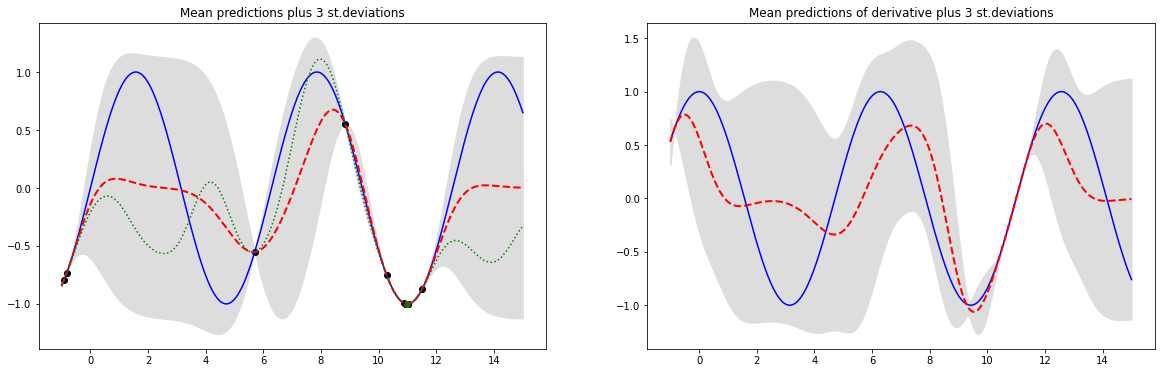

w:  [10.99198397]


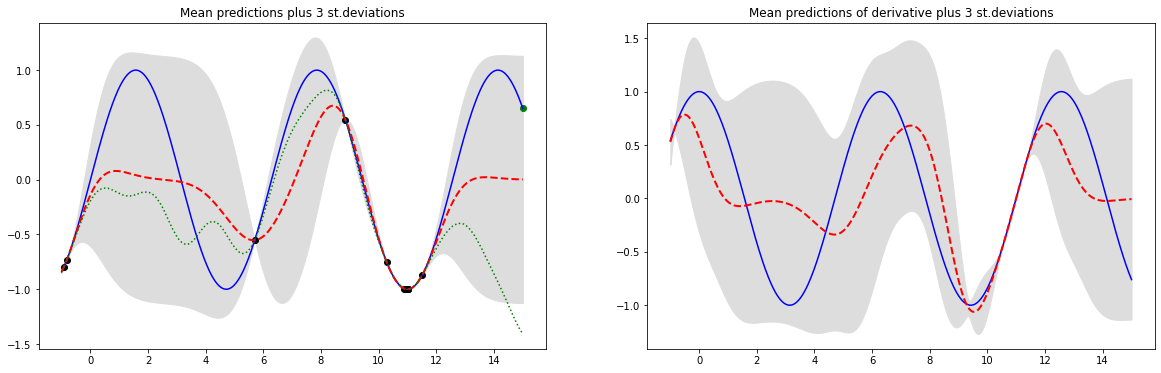

w:  [15.]


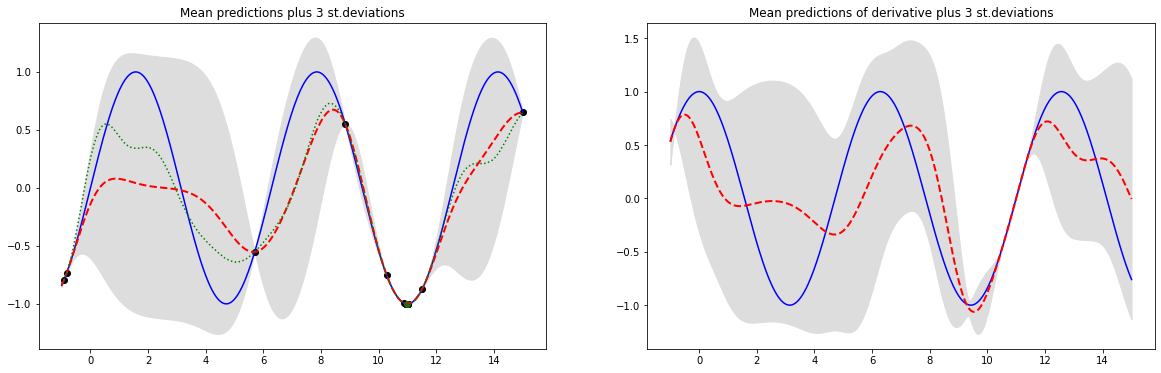

w:  [10.99198397]


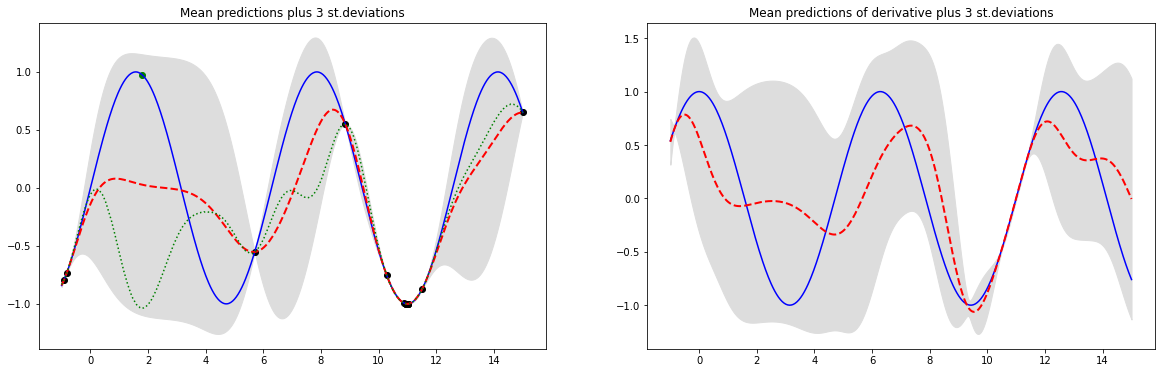

w:  [1.78957916]


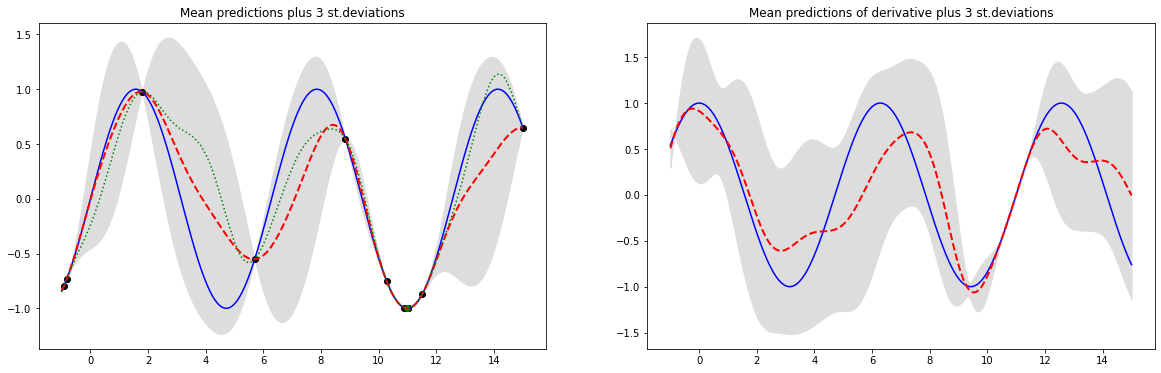

w:  [10.99198397]


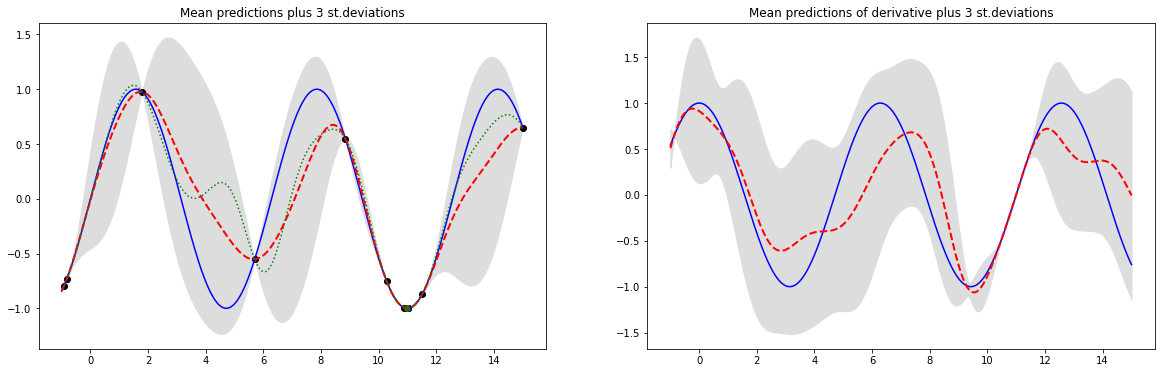

w:  [10.99198397]


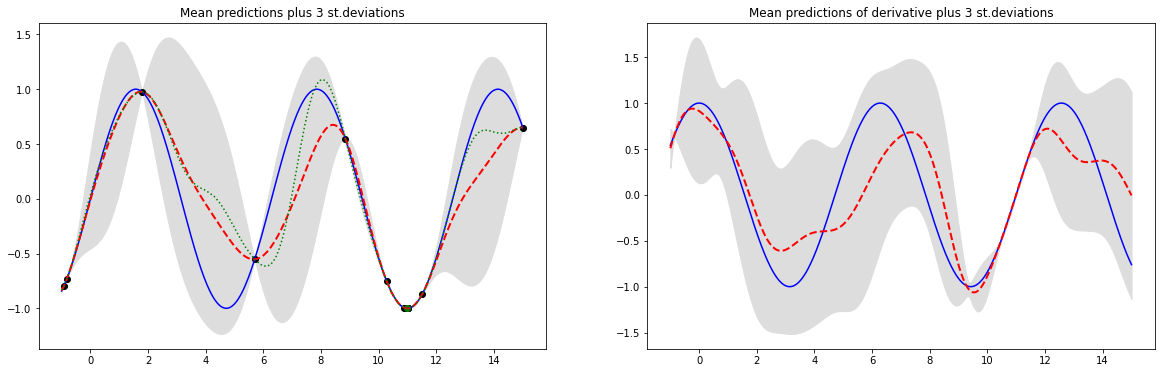

w:  [10.99198397]


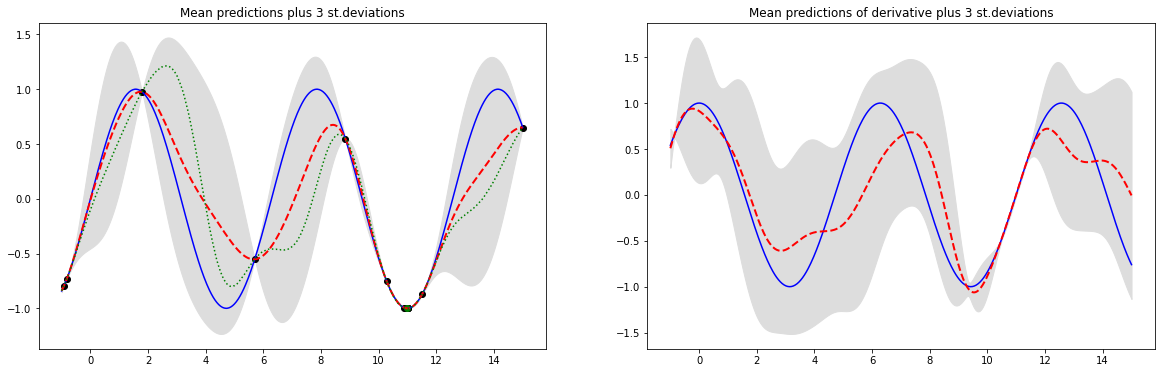

w:  [10.99198397]


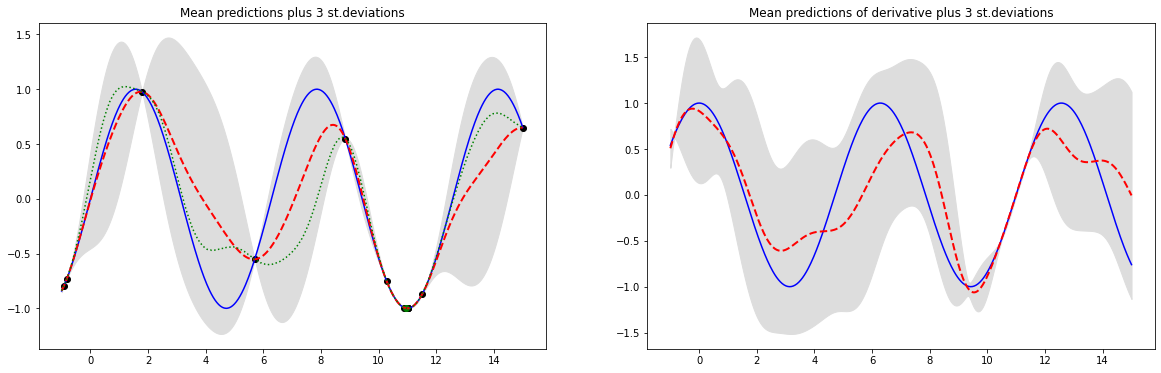

w:  [10.95991984]


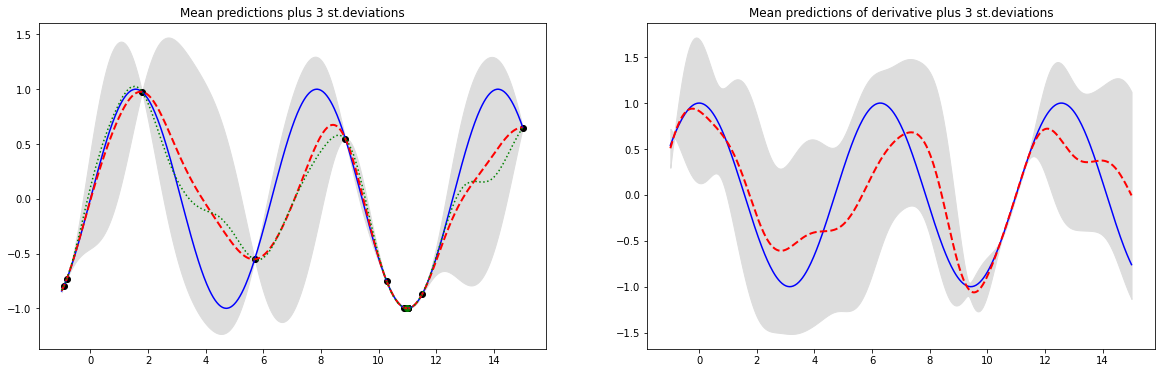

w:  [10.99198397]


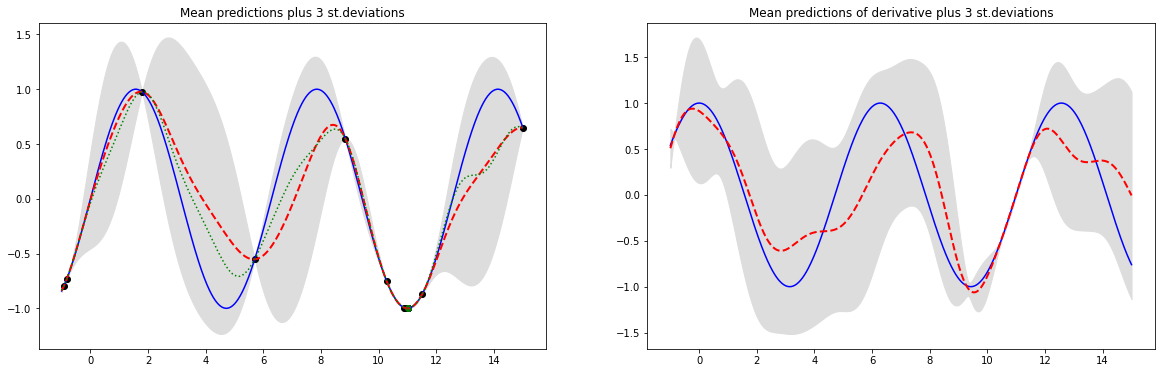

w:  [11.0240481]


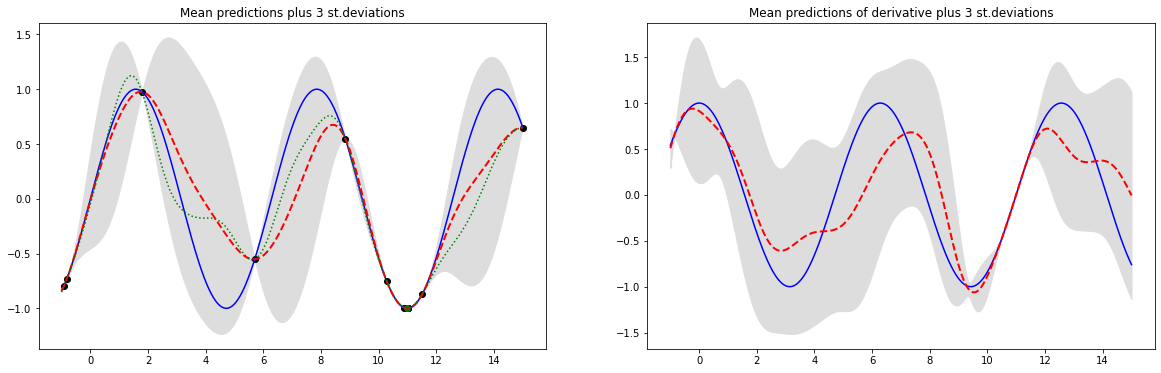

w:  [10.99198397]


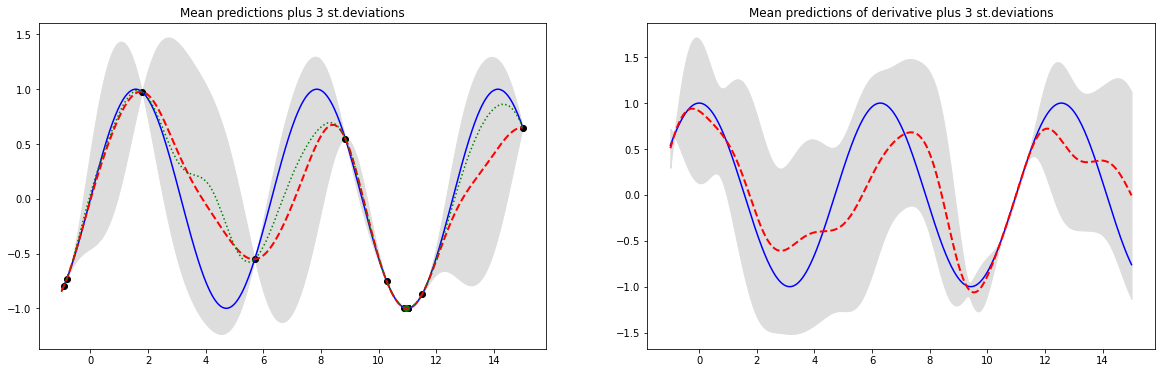

w:  [10.95991984]


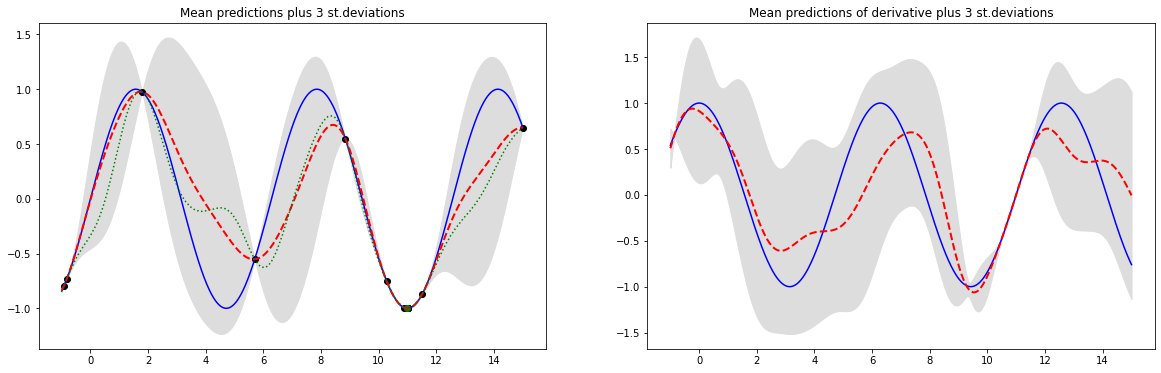

w:  [10.99198397]


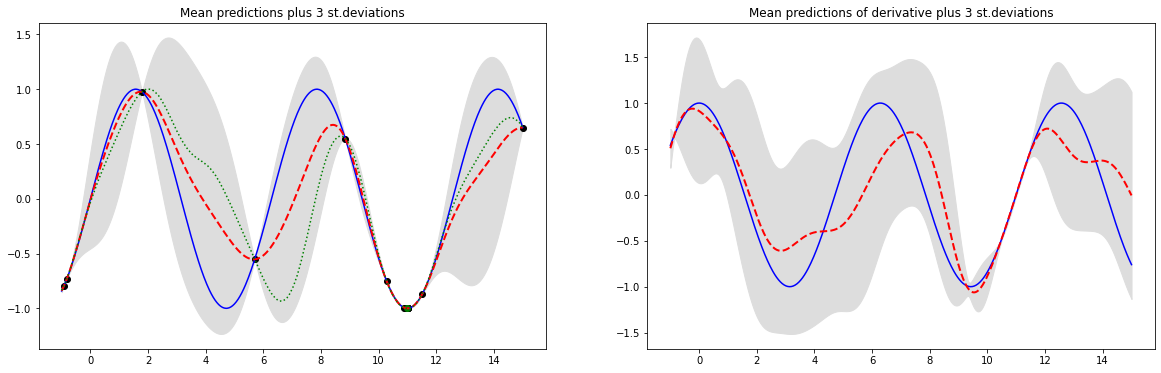

w:  [10.99198397]


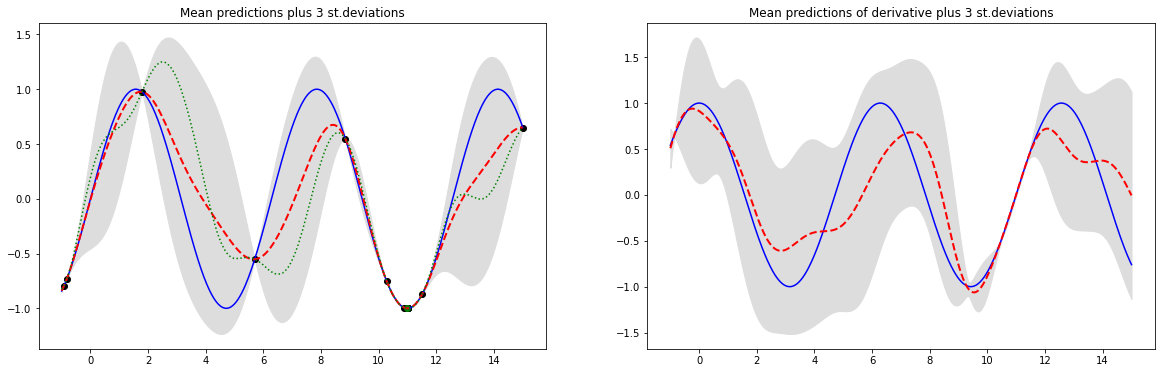

w:  [10.99198397]


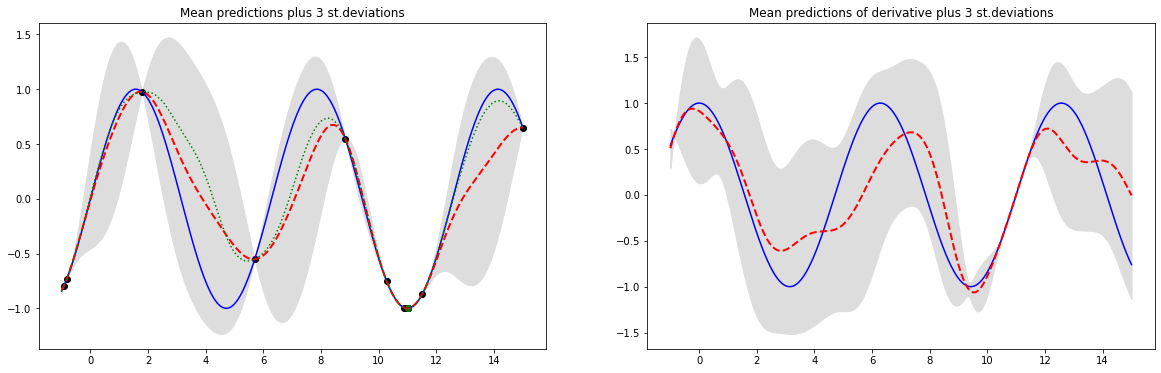

w:  [11.0240481]


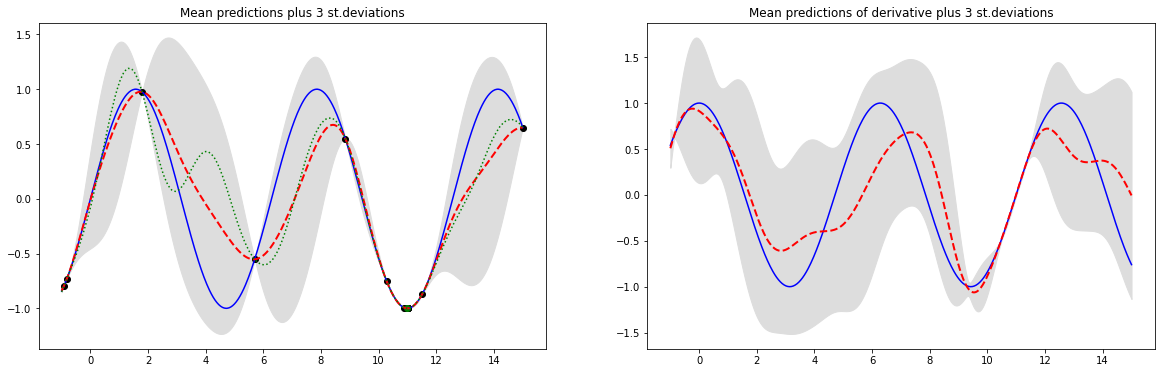

w:  [10.99198397]


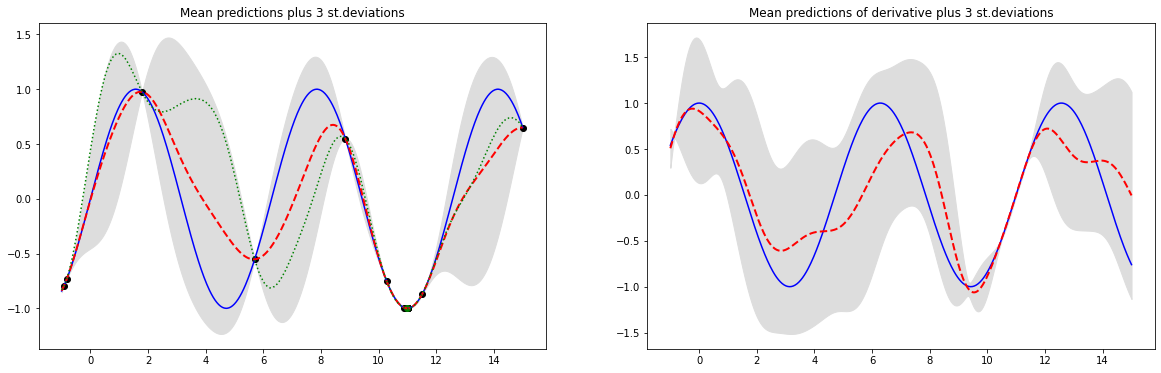

w:  [10.99198397]


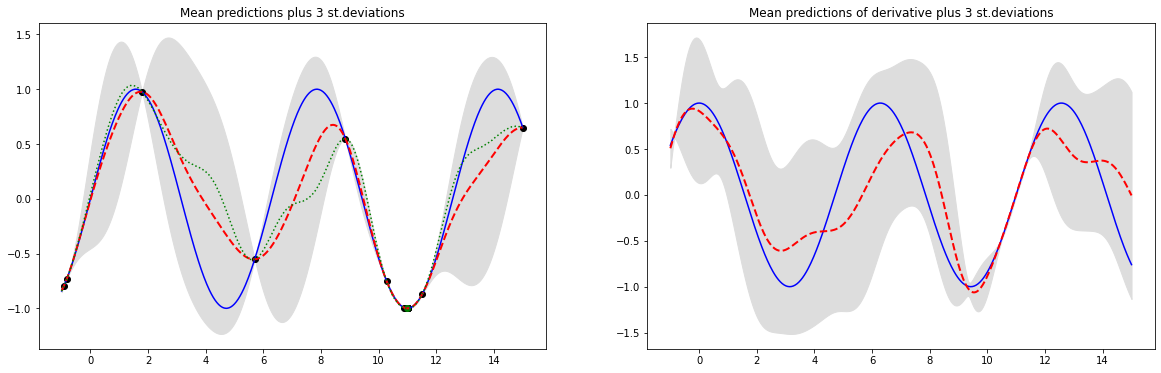

w:  [10.99198397]


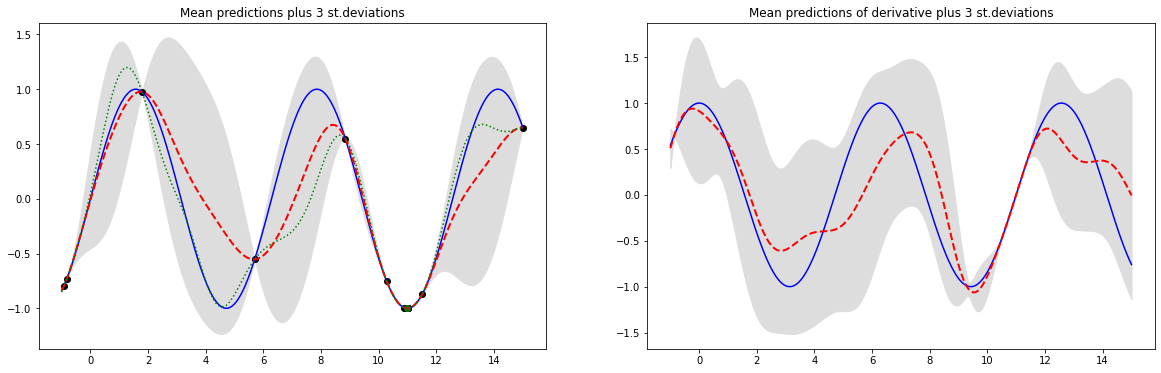

w:  [10.99198397]


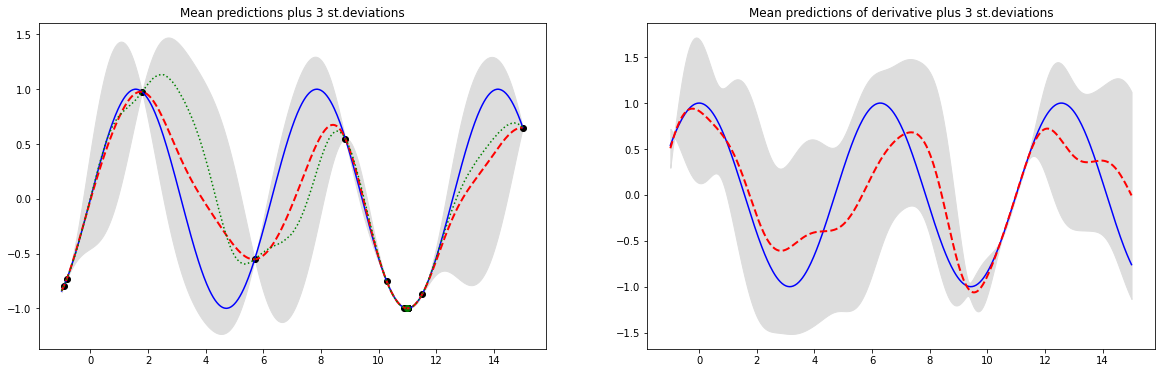

w:  [10.99198397]


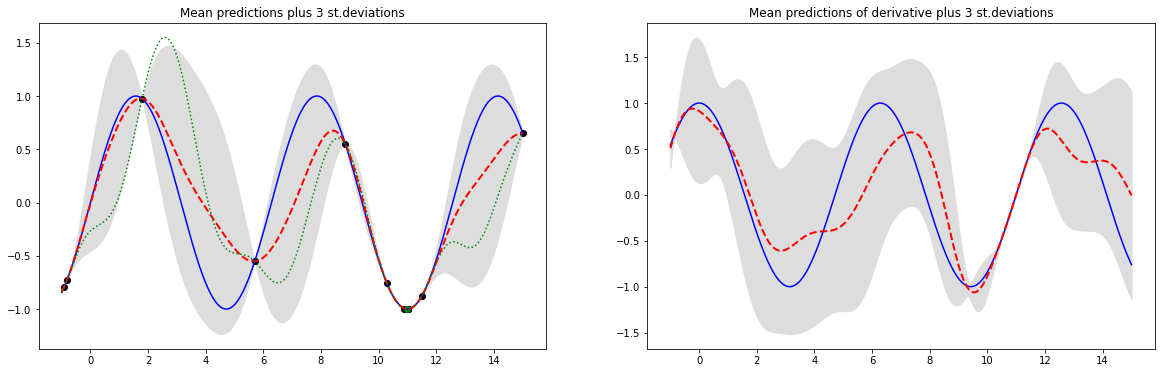

w:  [10.99198397]


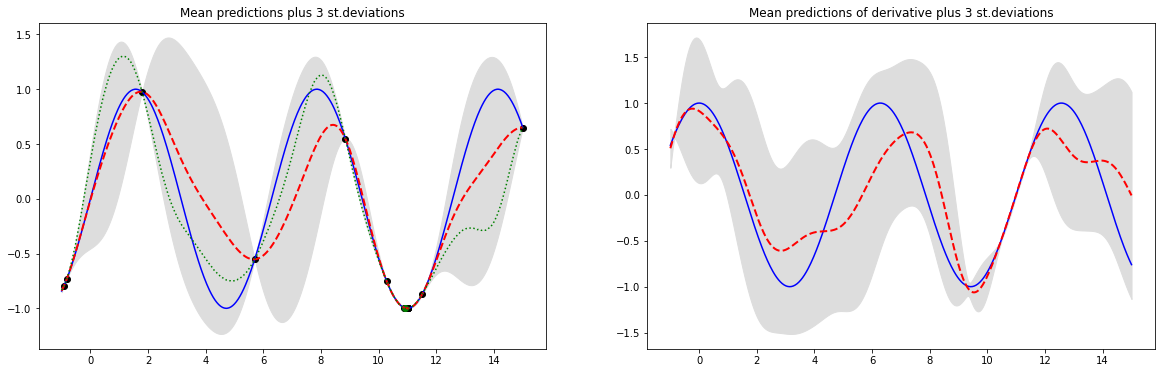

w:  [10.92785571]


In [22]:
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 40
history = []

w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    mu_grad = np.squeeze(mu_grad)
    s_grad = np.sqrt(np.diag(covar_grad))
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, dim)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'go')
    
    ax1.plot(Grid.flat, np.sin(Grid.flat), 'b-')
#     ax1.plot(Grid.flat, functions.Ackley_1().func(Grid), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(Grid, mu, 'r--', lw=2)
    ax1.plot(Grid.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
#     ax2.plot(Grid.flat, np.cos(Grid.flat) + 0.1, 'b-') 
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")
    ax2.plot(Grid.flat, approx_grad, 'b-')
    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])
    
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

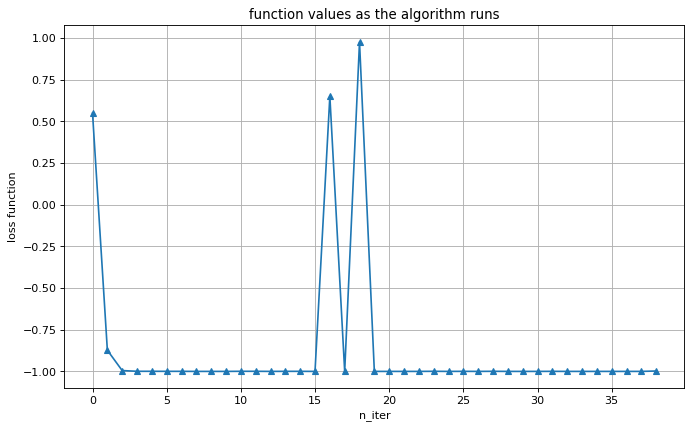

In [23]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [24]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# filenames = []
# for i in range(1, n_iter):
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     filenames.append(filename)

# frames=[]
# for filename in filenames:
#     frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'Ackley_noise.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)